# Localized Exploratory Analysis

This exploratory analysis was done with the purpose of understanding the behavior of the meteorological variables with the Dengue variables in various municipalities. It is worth noting that the files read in this notebook have already been preprocessed. This notebook is designed to receive any municipality and run the analysis for the set of municipalities with few modifications to the code.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
sns.set_style("ticks")
import pandas as pd
from datetime import datetime
import glob
import os
from modules import  data_management as dm
from modules import  preprocessing as prep
from modules import visualization as viz
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams.update({'font.size': 12})
%load_ext autoreload
%autoreload 2

# Loading municipality metadata

In [2]:
path_data = "./local/data/prepared_per_city/"
df_cities = dm.read_cities_file()
df_cities

department   municipality   code                  dl_folder  \
0            Antioquia       Medellín  05001              MEDELLIN_DATA   
1            Magdalena    Santa Marta  47001           SANTA_MARTA_DATA   
2            Santander    Bucaramanga  68001           BUCARAMANGA_DATA   
3            Atlántico   Barranquilla  08001  SOLEDAD_BARRANQUILLA_DATA   
4            Atlántico        Soledad  08758  SOLEDAD_BARRANQUILLA_DATA   
5   Norte de Santander         Cúcuta  54001                CUCUTA_DATA   
6      Valle del Cauca           Cali  76001                  CALI_DATA   
7              Caquetá  Villavicencio  50001         VILLAVICENCIO_DATA   
8               Tolima         Ibagué  73001                IBAGUE_DATA   
9              Córdoba       Montería  23001              MONTERIA_DATA   
10           Antioquia          Bello  05088              MEDELLIN_DATA   

   starting_date                   stations_temp  \
0     2011/05/20  [27015330, 27015310, 27015300]   
1     2008/06/28                      [15015120]   
2     2014/12/11                      [23195230]   
3     2013/05/03            [29045190, 29004520]   
4     2007/01/01                              []   
5     2006-09-03            [16015110, 16015501]   
6     2006/11/24            [26085170, 26055120]   
7     2007/03/18            [35035100, 35025110]   
8     2007/01/01                              []   
9     2007/01/01                              []   
10    2007/01/01                              []   

                      stations_hum                             stations_prec  \
0   [27015330, 27015310, 27015300]            [27015330, 27015290, 27011270]   
1                       [15015120]            [15015050, 15010501, 15015120]   
2                       [23195230]                                [23195230]   
3                       [29045190]            [29045120, 29040450, 29045190]   
4                               []                                        []   
5             [16015110, 16015501]            [16015110, 16015010, 16015501]   
6             [26085170, 26055120]            [26055120, 26080310, 26085170]   
7             [35035100, 35025110]  [35030380, 35030370, 35030100, 35035020]   
8                               []                                        []   
9                               []                                        []   
10                              []                                        []   

   stations_rad    range_temp    range_hum  
0            []  [15.5, 37.5]  [15, 99.99]  
1            []    [17.5, 40]  [40, 99.99]  
2            []      [17, 40]  [30, 99.99]  
3            []      [22, 45]  [45, 99.99]  
4            []            []           []  
5            []    [17.5, 45]  [30, 99.99]  
6            []    [16.5, 45]  [30, 99.99]  
7            []      [20, 45]  [35, 99.99]  
8            []            []           []  
9            []      [22, 45]  [45, 99.99]  
10           []      [22, 45]  [45, 99.99]

In [29]:
figsize = (15,10)
dpi = 87
dates_range = (pd.to_datetime("2007/01/01"),pd.to_datetime("2021/01/31"))

indexes = [3, 1, 0, 5, 6, 7]
dic_municipios = {}
params_to_get = ["department","municipality","dl_folder","code", "starting_date"]
path_data = f'local/data/prepared_per_city/'


for index in indexes:
    params_city = {param:df_cities.loc[index,param] for param in params_to_get}
    name = params_city["municipality"]
    dic_municipios[name] = params_city
    df_municipio = pd.read_csv(path_data+f"{prep.municipality_name_to_filename(params_city['municipality'])}_consolidado_{params_city['starting_date'][0:4]}_2020.csv", index_col = 0, parse_dates= True, dtype = {'COD_MUNICIPIO':str})
    df_municipio["CITY"] = name
    dic_municipios[name]["df"] = df_municipio


In [15]:
municipios = list(dic_municipios.keys())
municipios

['Barranquilla', 'Santa Marta', 'Medellín', 'Cúcuta', 'Cali', 'Villavicencio']

# TEMPERATURE PLOTS

The temperature variable must always looked at in 3 different forms, the maximum, minimum and mean temperature. 

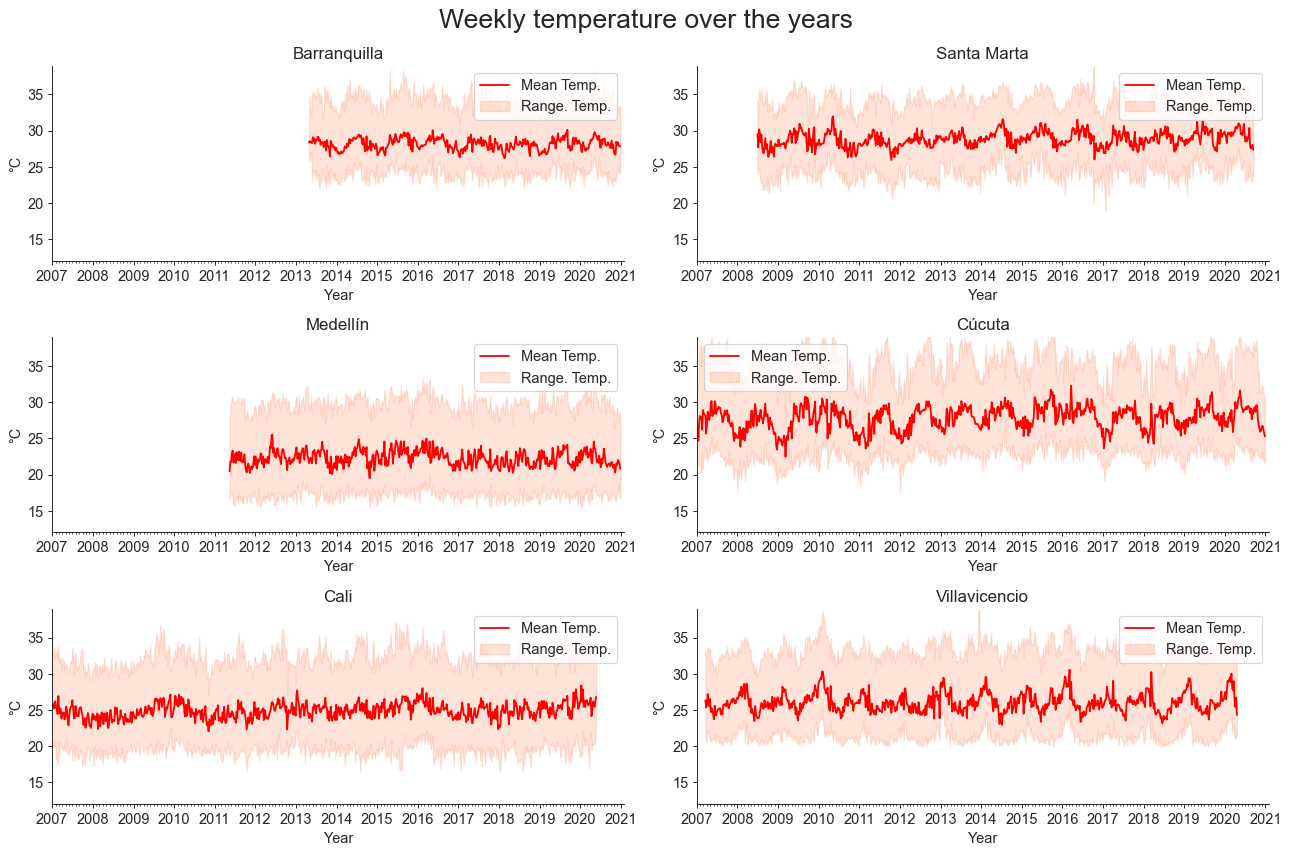

In [30]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    x_array = [df.index]
    y_array = [df["TEMPERATURE_MEAN"], df["TEMPERATURE_AMIN"], df["TEMPERATURE_AMAX"]]
    labels_array = ["Mean Temp.", "Range. Temp."]
    colors = ["red","orangered"]
    title = n
    ylabel = "°C"
    xlabel = "Year"
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title, xlabel, ylabel, xlim, (12, 39), "lineplot", fulldates = True)
    plt.suptitle("Weekly temperature over the years", fontsize="22")
fig.tight_layout()
plt.show()

# Temperature trend plots

Here we visualize thre trend of temperature over the years for all 6 cities. For all cities, there were peaks in temperature for years 2010 (if data was available) and 2015-2016.

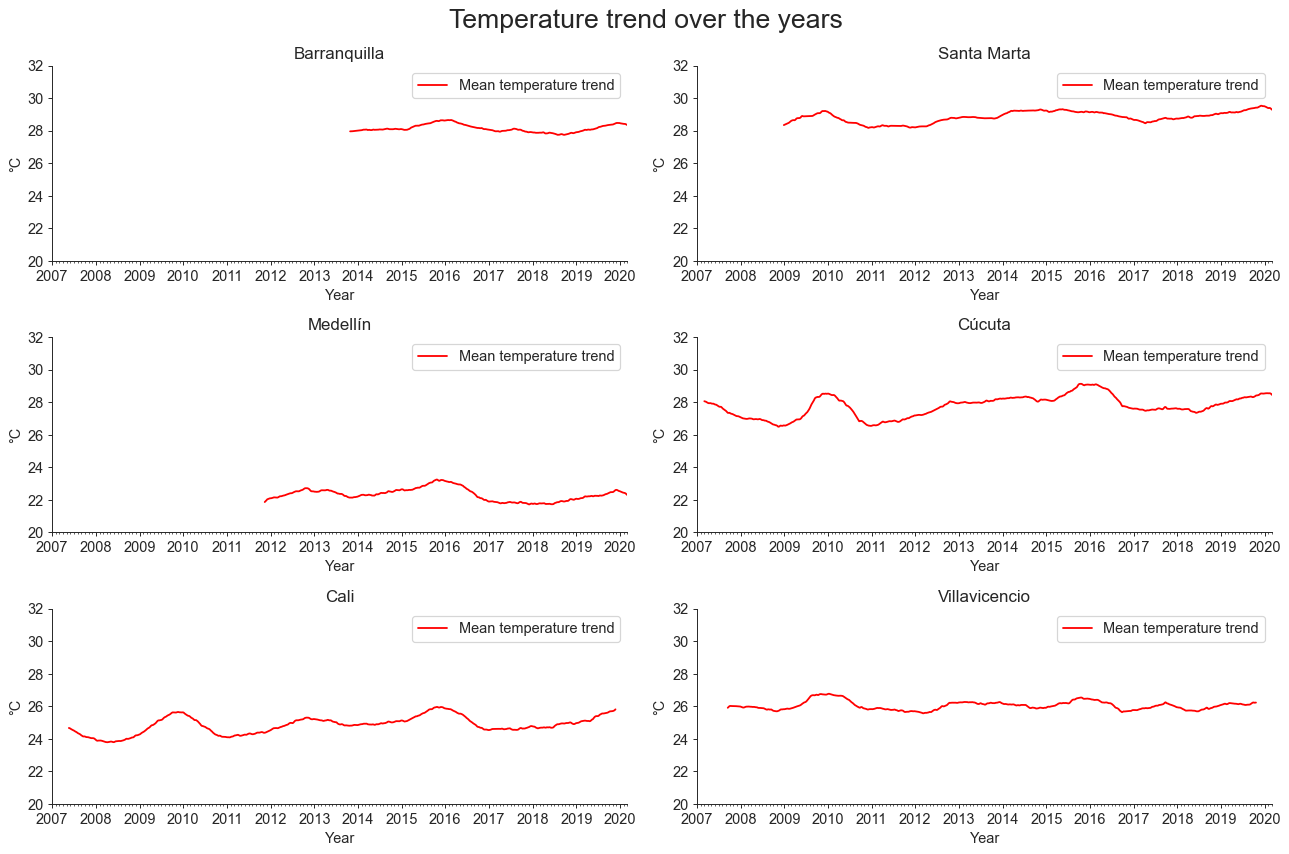

In [17]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    decomp = seasonal_decompose(df["TEMPERATURE_MEAN"].dropna())
    x_array = [df["TEMPERATURE_MEAN"].dropna().index]
    y_array = [decomp.trend]
    labels_array = ["Mean temperature trend"]
    colors = ["red"]
    title = n
    ylabel = "°C"
    xlabel = "Year"
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title, xlabel, ylabel, xlim, (20, 32), "lineplot", fulldates = True)
    plt.suptitle("Temperature trend over the years", fontsize = "22")

fig.tight_layout()
plt.show()

In [68]:
"""
df_filt = df[(df["ANO"]>=2007) & (df["ANO"]<=2019)]
x_array = [df_filt["ANO"]]*4
y_array = [df_filt["TEMPERATURE_MEAN"], df_filt["TEMPERATURE_AMIN"],df_filt["TEMPERATURE_AMAX"] , df_filt["TEMPERATURE_RANGE"]]
labels_array = ["Mean Temp.", "Min. Temp.", "Max. Temp." , "Temp. Range"]
colors = ["forestgreen","darkblue","orangered","black"]
title = "Temperature over the years for " + municipality
ylabel = "°C"
xlabel = "Date"
plot_time_series(x_array, y_array, labels_array,colors,title,  xlabel,ylabel, "lineplot")
""";

Text(0.5, 0, 'Month')

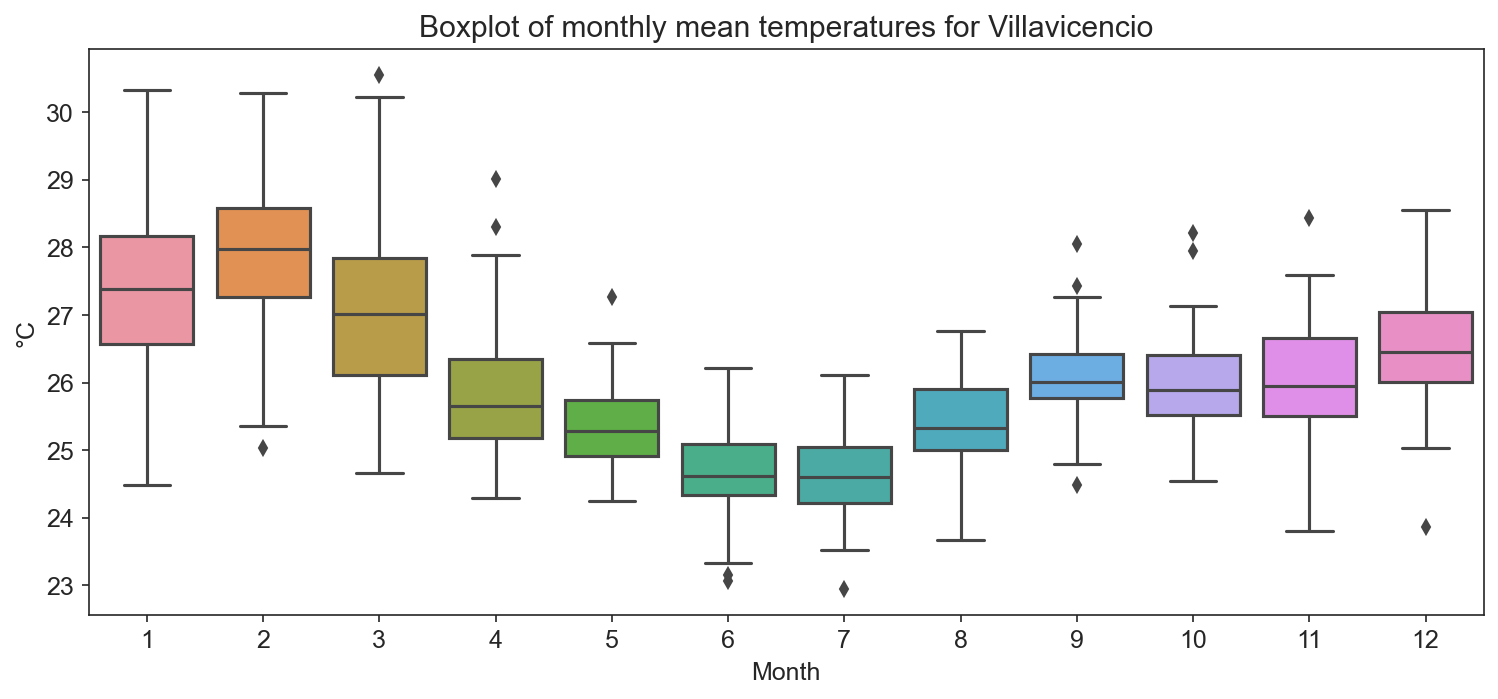

In [70]:
df = dic_municipios["Villavicencio"]["df"]
municipality = "Villavicencio"
fig, axes = plt.subplots(1,1, figsize=(12,5), dpi = 150)
sns.boxplot(x=df.index.month, y=df["TEMPERATURE_MEAN"])
axes.set_title("Boxplot of monthly mean temperatures for " + municipality)
axes.set_ylabel("°C")
axes.set_xlabel("Month")

# HUMIDITY PLOTS

The humidity variable must always looked at in 3 different forms, the maximum, minimum and mean humidity. 

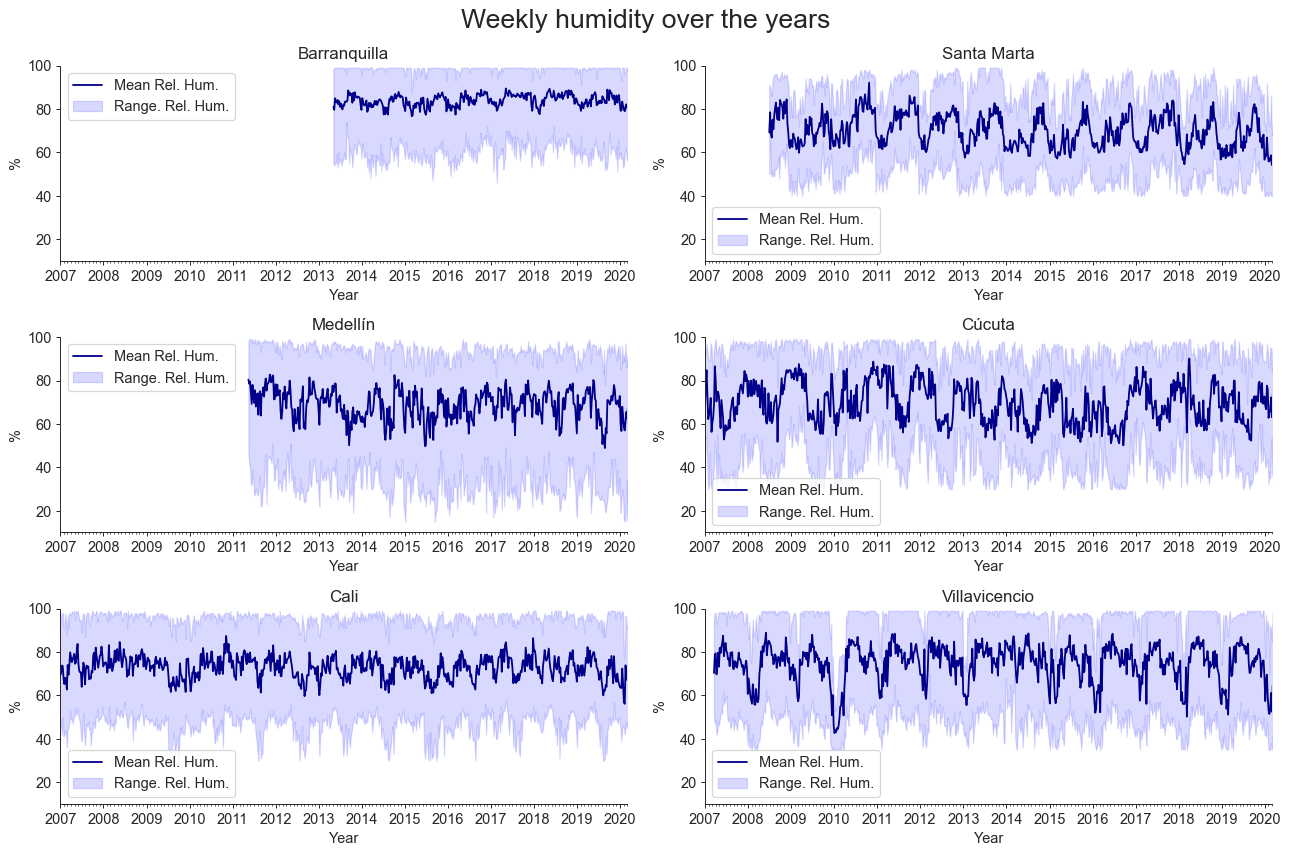

In [18]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    x_array = [df.index]
    y_array = [df["REL_HUMIDITY_MEAN"], df["REL_HUMIDITY_AMIN"],df["REL_HUMIDITY_AMAX"] ]
    labels_array = ["Mean Rel. Hum.", "Range. Rel. Hum."]
    title = n
    colors = ["darkblue","blue"]
    ylabel = "%"
    xlabel = "Year"
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title, xlabel, ylabel, xlim, (10, 100), "lineplot", fulldates = True)
    plt.suptitle("Weekly humidity over the years", fontsize="22")
fig.tight_layout()
plt.show()

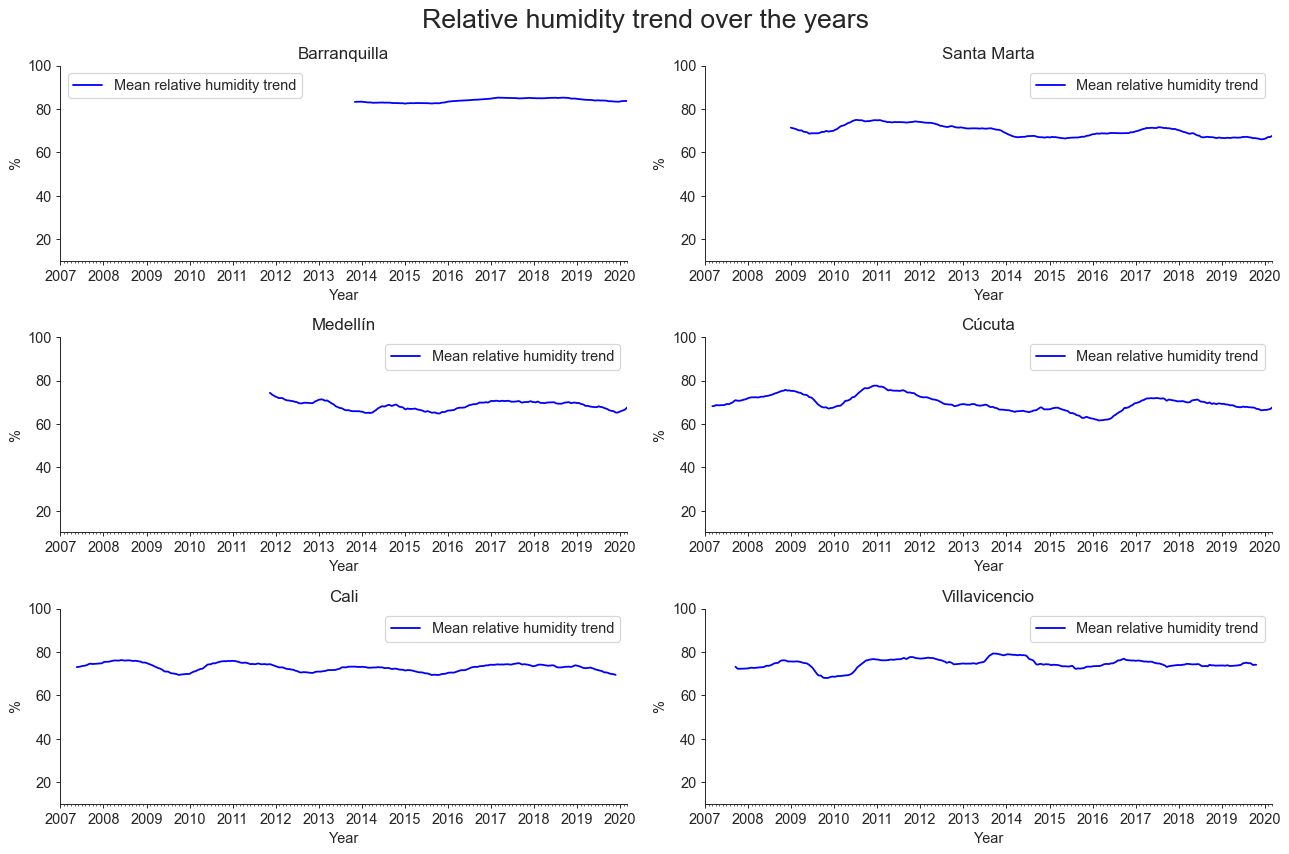

In [19]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    decomp = seasonal_decompose(df["REL_HUMIDITY_MEAN"].dropna())
    x_array = [df["REL_HUMIDITY_MEAN"].dropna().index]
    y_array = [decomp.trend]
    labels_array = ["Mean relative humidity trend"]
    colors = ["blue"]
    title = n
    ylabel = "%"
    xlabel = "Year"
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title, xlabel, ylabel, xlim, (10, 100), "lineplot", fulldates = True)
    plt.suptitle("Relative humidity trend over the years", fontsize = "22")

fig.tight_layout()
plt.show()

In [88]:
"""x_array = [df.index]*3
y_array = [df["REL_HUMIDITY_MEAN"], df["REL_HUMIDITY_AMIN"],df["REL_HUMIDITY_AMAX"] ]
labels_array = ["Mean Rel. Hum.", "Min. Rel. Hum.", "Max. Rel. Hum."]
title = "Weekly humidity over the years for " + municipality
colors = ["forestgreen","darkblue","orangered"]
ylabel = "%"
xlabel = "Date"
plot_time_series(x_array, y_array, labels_array, colors,title,  xlabel,ylabel, "lineplot", fulldates = True)

x_array = [df_filt["ANO"]]*3
y_array = [df_filt["REL_HUMIDITY_MEAN"], df_filt["REL_HUMIDITY_AMIN"],df_filt["REL_HUMIDITY_AMAX"] ]
labels_array = ["Mean Rel. Hum.", "Min. Rel. Hum.", "Max. Rel. Hum."]
title = "Humidity over the years for " + municipality
ylabel = "%"
xlabel = "Date"
colors = ["forestgreen","darkblue","orangered"]
plot_time_series(x_array, y_array, labels_array, colors, title,  xlabel,ylabel, "lineplot", fulldates = False)
""";

Text(0.5, 0, 'Month')

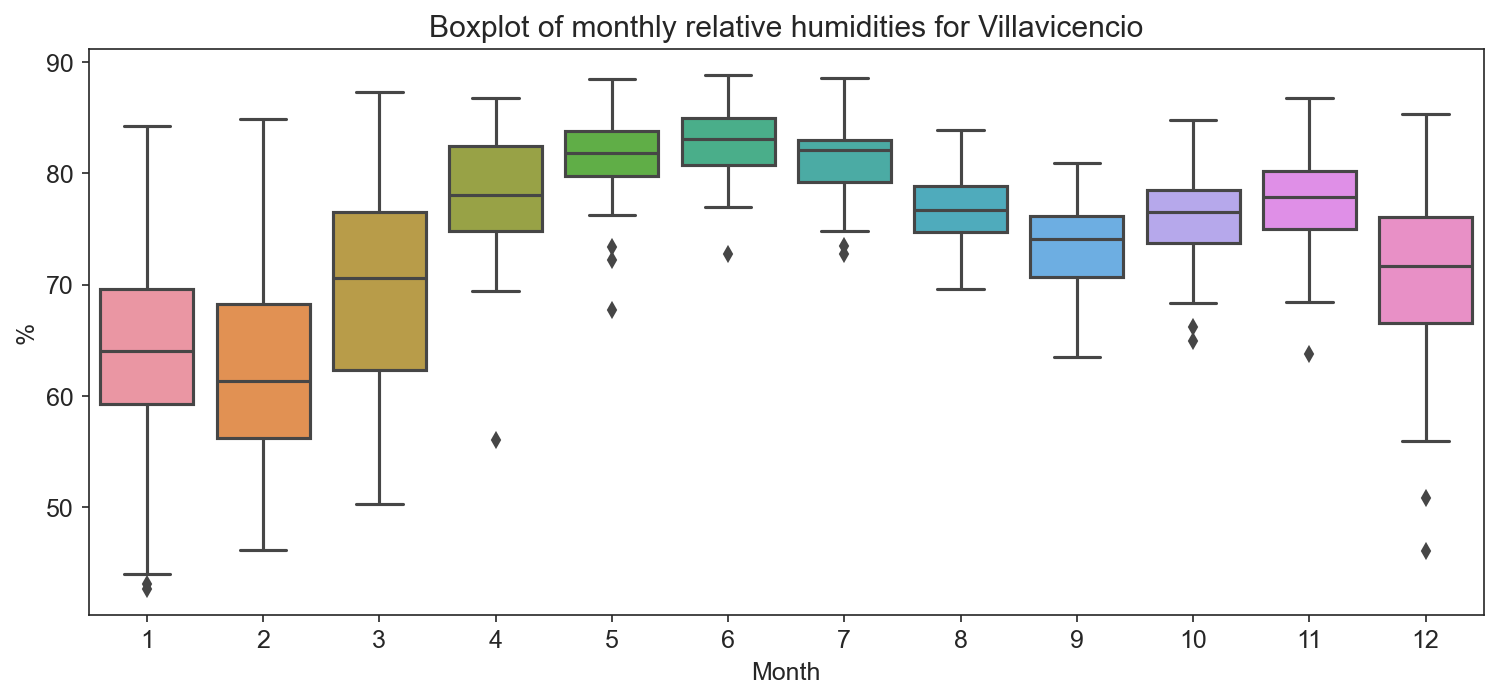

In [540]:
fig, axes = plt.subplots(1,1, figsize=(12,5), dpi = 150)
sns.boxplot(x=df.index.month, y=df["REL_HUMIDITY_MEAN"])
axes.set_title("Boxplot of monthly relative humidities for " + municipality)
axes.set_ylabel("%")
axes.set_xlabel("Month")

# PRECIPITATION PLOTS

The precipitation variable, due to its nature, must be analyzed as the total precipitation. The maximum and minimums in this variable do not describe the general behavior of the variable.

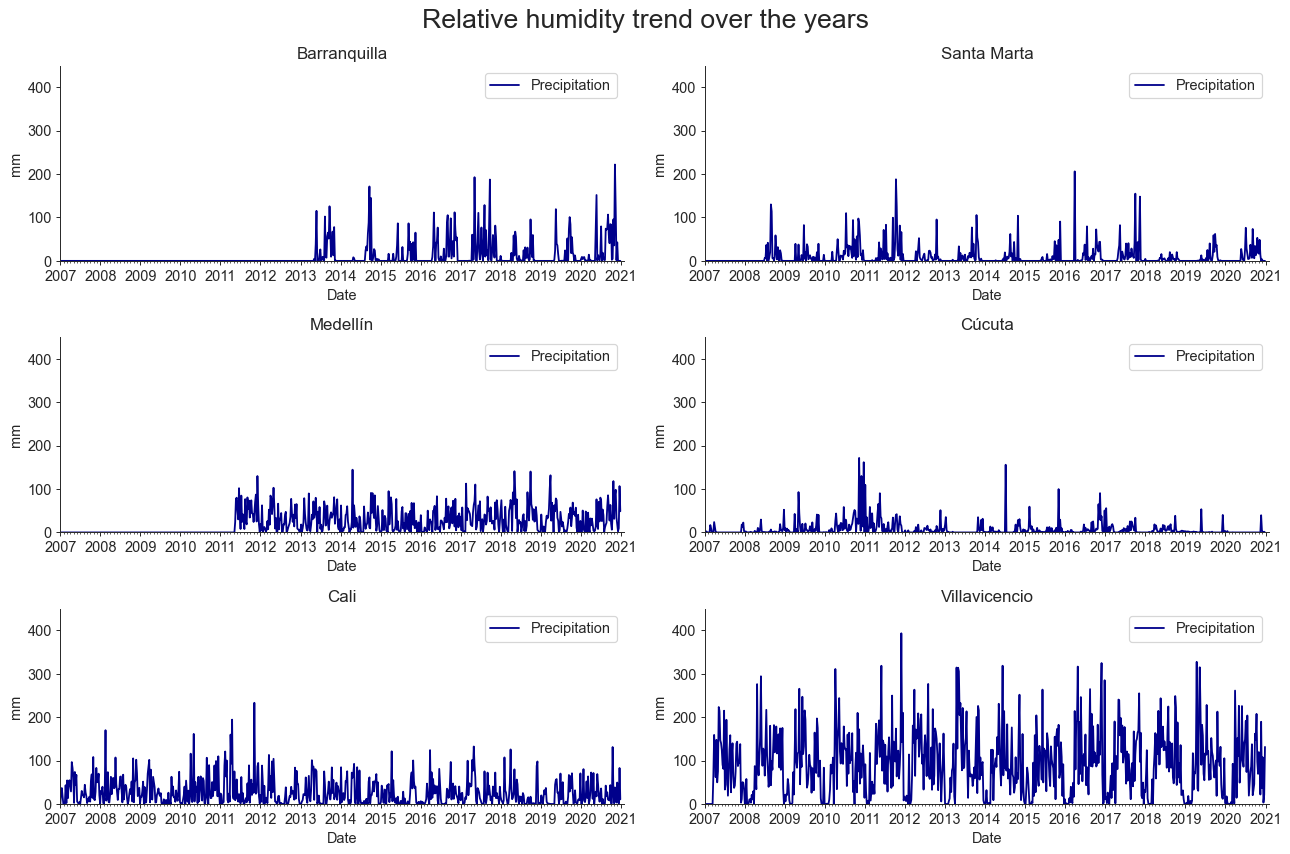

In [31]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    x_array = [df.index]
    y_array = [df["PRECIPITATION"]]
    labels_array = ["Precipitation"]
    title = n
    ylabel = "mm"
    xlabel = "Date"
    colors = ["darkblue"]
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title,  
                     xlabel, ylabel, xlim, (0,450), "lineplot", fulldates = True)
    plt.suptitle("Relative humidity trend over the years", fontsize = "22")
fig.tight_layout()
plt.show()

Text(0.5, 0, 'Month')

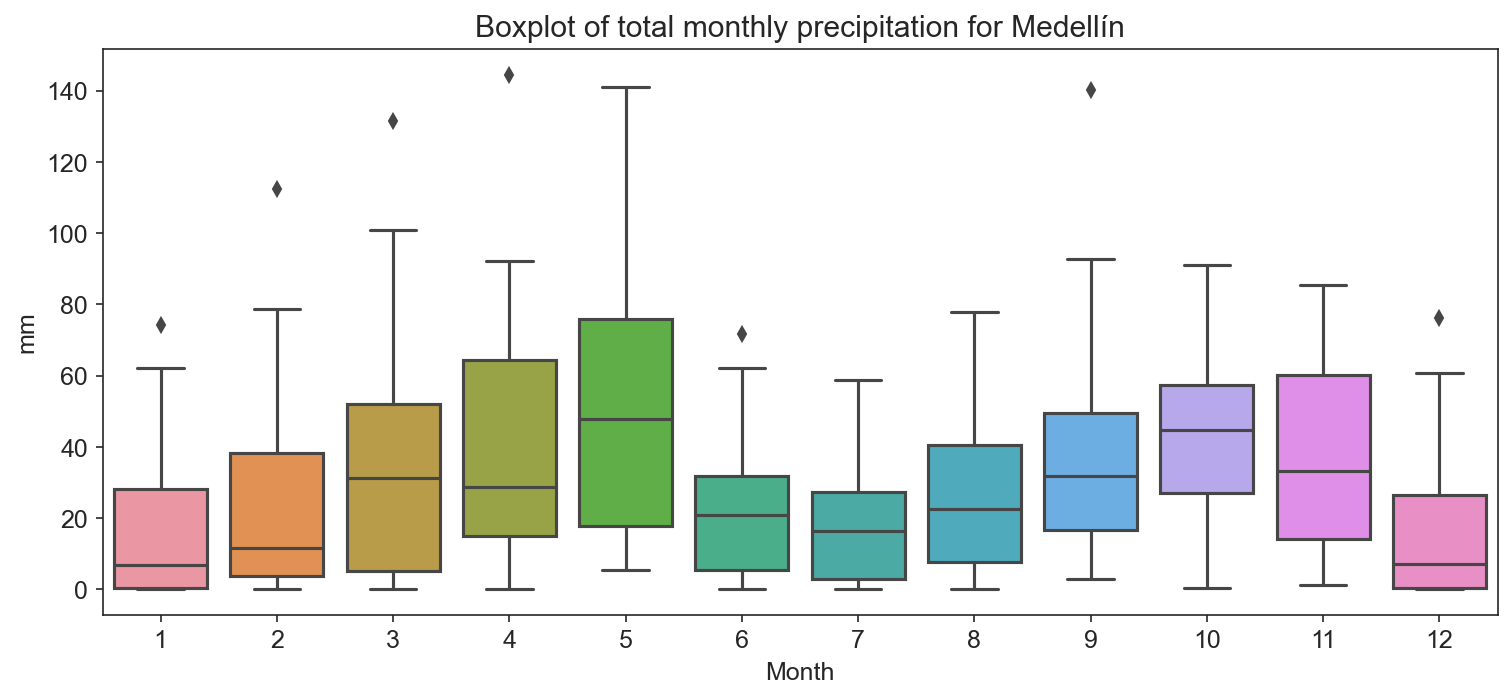

In [196]:
fig, axes = plt.subplots(1,1, figsize=(12,5), dpi = 150)
sns.boxplot(x=df.index.month, y=df["PRECIPITATION"])
axes.set_title("Boxplot of total monthly precipitation for " + municipality)
axes.set_ylabel("mm")
axes.set_xlabel("Month")

In [197]:
df.columns

Index(['COD_DPTO', 'COD_MUNICIPIO', 'POBLACION', 'ANO', 'SEMANA',
       'PRECIPITATION', 'DRY_DAYS', 'TEMPERATURE_AMAX', 'REL_HUMIDITY_AMAX',
       'TEMPERATURE_AMIN', 'TEMPERATURE_RANGE', 'REL_HUMIDITY_AMIN',
       'TEMPERATURE_MEAN', 'REL_HUMIDITY_MEAN', 'MEI', 'ONI', 'SST1+2', 'SST3',
       'SST4', 'SST3.4', 'TNI', 'CAR', 'NTA', 'DENGUE', 'DENGUE GRAVE',
       'MORTALIDAD POR DENGUE'],
      dtype='object')

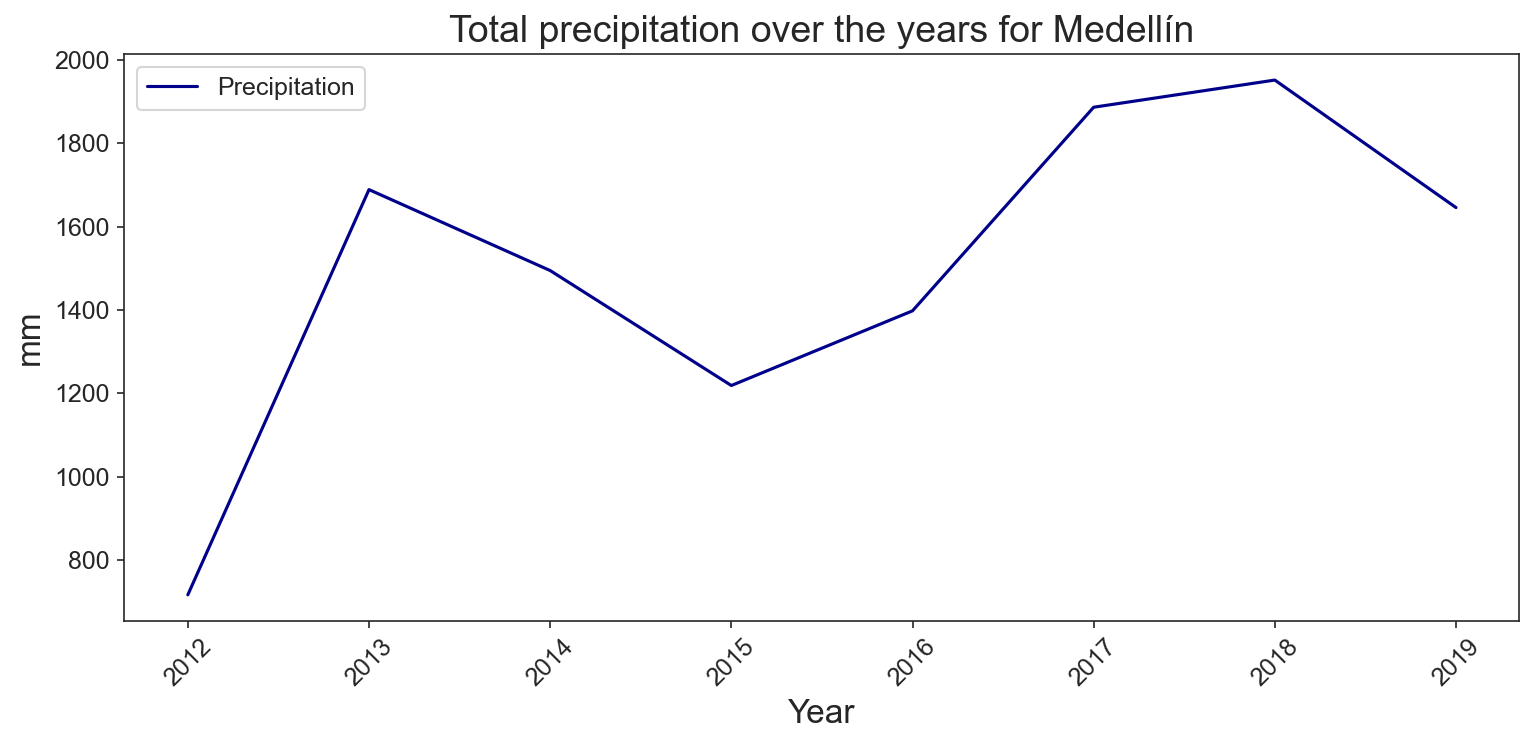

In [198]:
df_prec_yearly = df[(df.index.year >= 2007) & (df.index.year <= 2019)]
df_prec_yearly = df_prec_yearly[["PRECIPITATION","DRY_DAYS"]]
df_prec_yearly = df_prec_yearly.groupby(df_prec_yearly.index.year).sum()
x_array = [df_prec_yearly.index]
y_array = [df_prec_yearly["PRECIPITATION"]]
labels_array = ["Precipitation"]
title = "Total precipitation over the years for " + municipality
ylabel = "mm"
xlabel = "Year"
colors = ["darkblue"]
plot_time_series(x_array, y_array, labels_array, colors, title, xlabel,ylabel, "lineplot", fulldates = False)

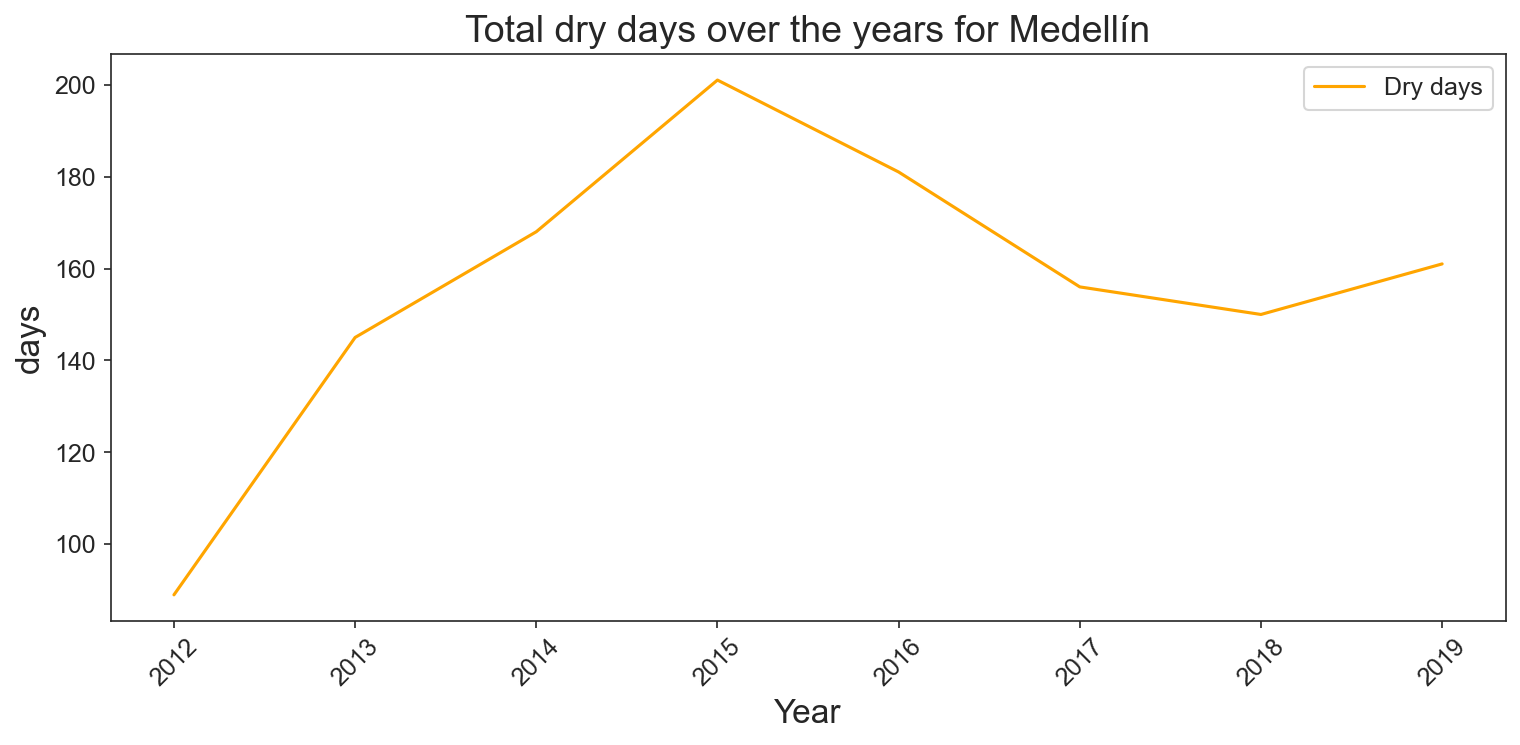

In [199]:
x_array = [df_prec_yearly.index]
y_array = [df_prec_yearly["DRY_DAYS"]]
labels_array = ["Dry days"]
title = "Total dry days over the years for " + municipality
ylabel = "days"
xlabel = "Year"
colors = ["orange"]
plot_time_series(x_array, y_array, labels_array, colors, title,  xlabel,ylabel, "lineplot", fulldates = False)

# NIÑO PLOTS

The Niño indexes are also very important features to analyze in this project. That is why it is interesting to analyze and understand their behavior in time series plots.

In [200]:
df.columns

Index(['COD_DPTO', 'COD_MUNICIPIO', 'POBLACION', 'ANO', 'SEMANA',
       'PRECIPITATION', 'DRY_DAYS', 'TEMPERATURE_AMAX', 'REL_HUMIDITY_AMAX',
       'TEMPERATURE_AMIN', 'TEMPERATURE_RANGE', 'REL_HUMIDITY_AMIN',
       'TEMPERATURE_MEAN', 'REL_HUMIDITY_MEAN', 'MEI', 'ONI', 'SST1+2', 'SST3',
       'SST4', 'SST3.4', 'TNI', 'CAR', 'NTA', 'DENGUE', 'DENGUE GRAVE',
       'MORTALIDAD POR DENGUE'],
      dtype='object')

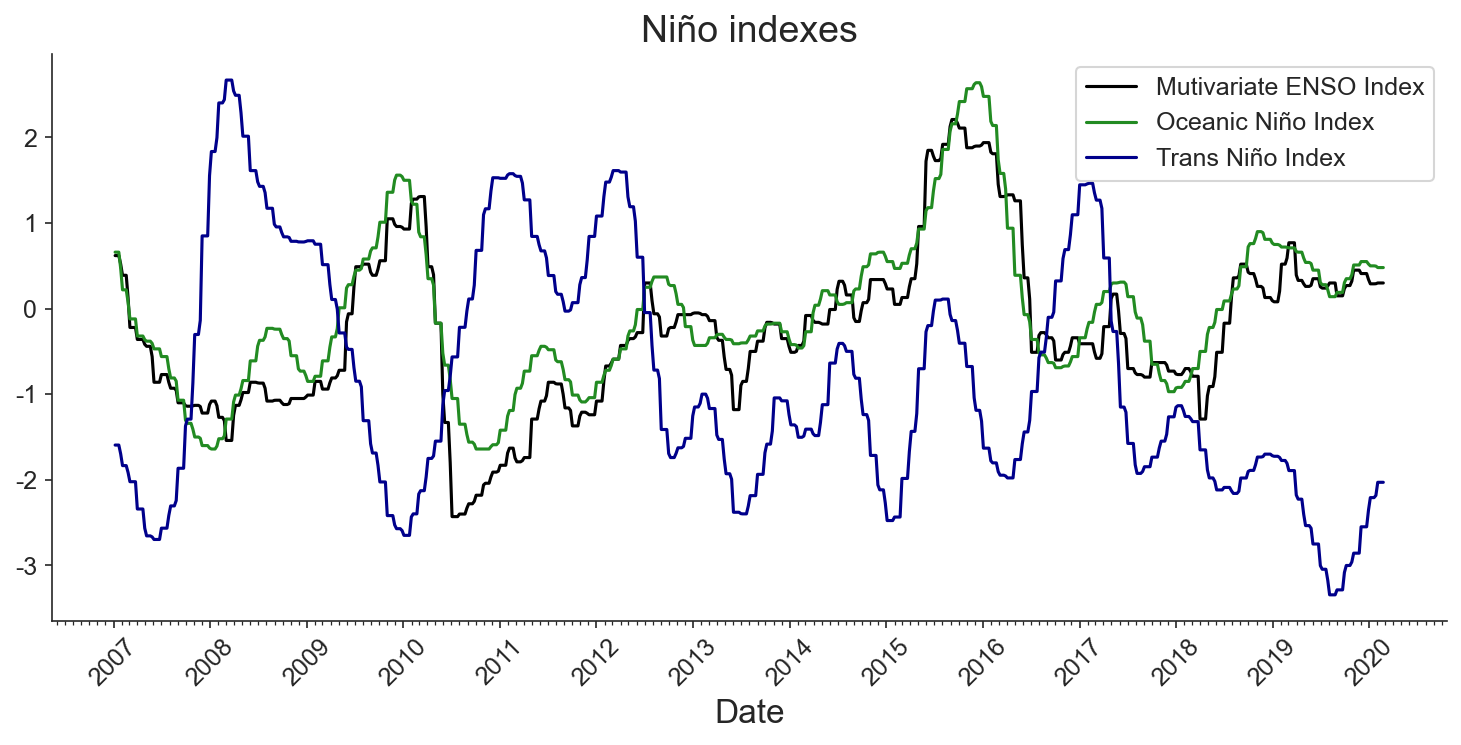

In [546]:
x_array = [df.index]*3
y_array = [df["MEI"], df["ONI"], df["TNI"]]
labels_array = ["Mutivariate ENSO Index", "Oceanic Niño Index", "Trans Niño Index"]
colors = ["black","forestgreen","darkblue","orangered","cyan","black"]
title = "Niño indexes"
ylabel = ""
xlabel = "Date"
plot_time_series(x_array, y_array, labels_array,colors,title,  xlabel,ylabel, "lineplot", fulldates = True)

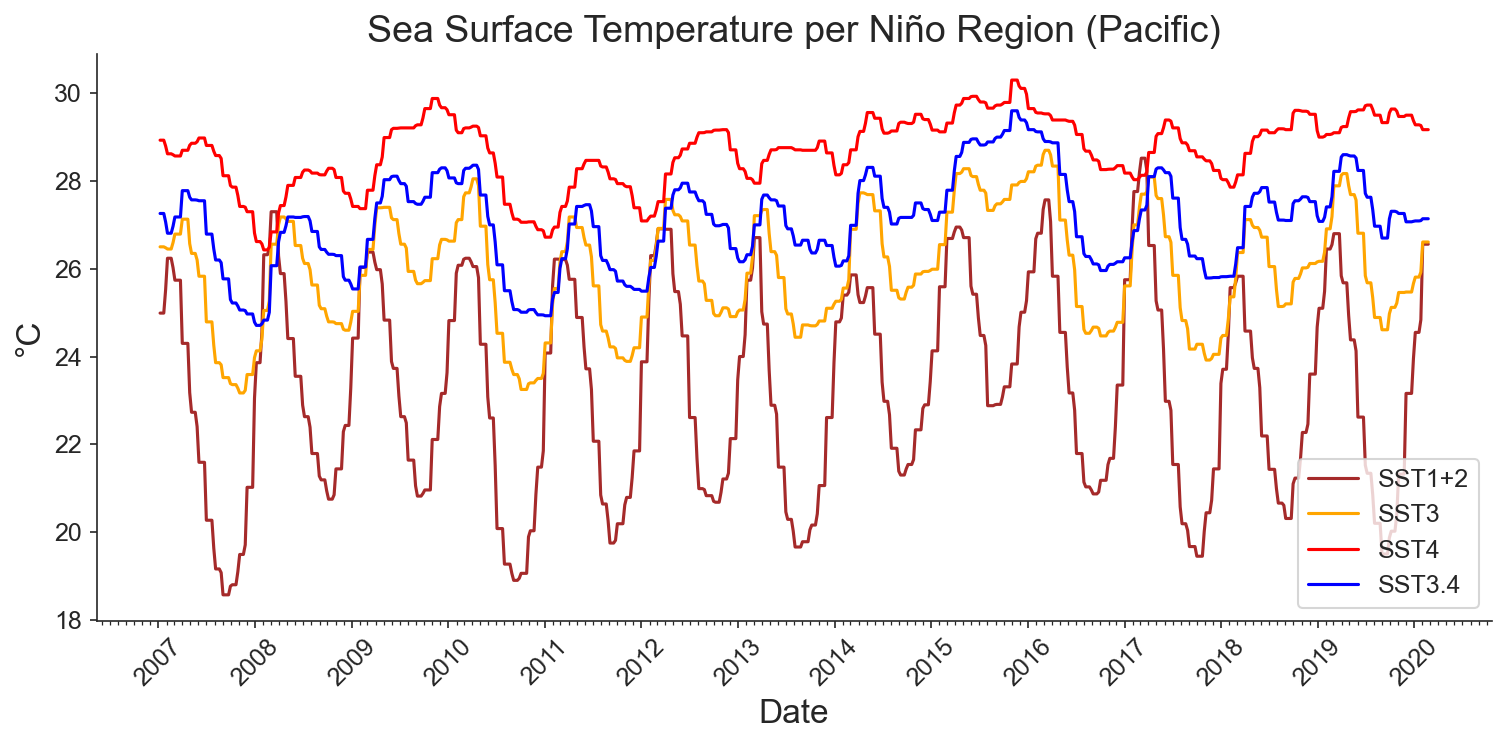

In [550]:
x_array = [df.index]*4
y_array = [df["SST1+2"], df["SST3"], df["SST4"], df["SST3.4"]]
labels_array = ["SST1+2", "SST3", "SST4", "SST3.4"]
colors = ["brown","orange","red","blue"]
title = "Sea Surface Temperature per Niño Region (Pacific)"
ylabel = "°C"
xlabel = "Date"
plot_time_series(x_array, y_array, labels_array,colors,title,  xlabel,ylabel, "lineplot", fulldates = True)

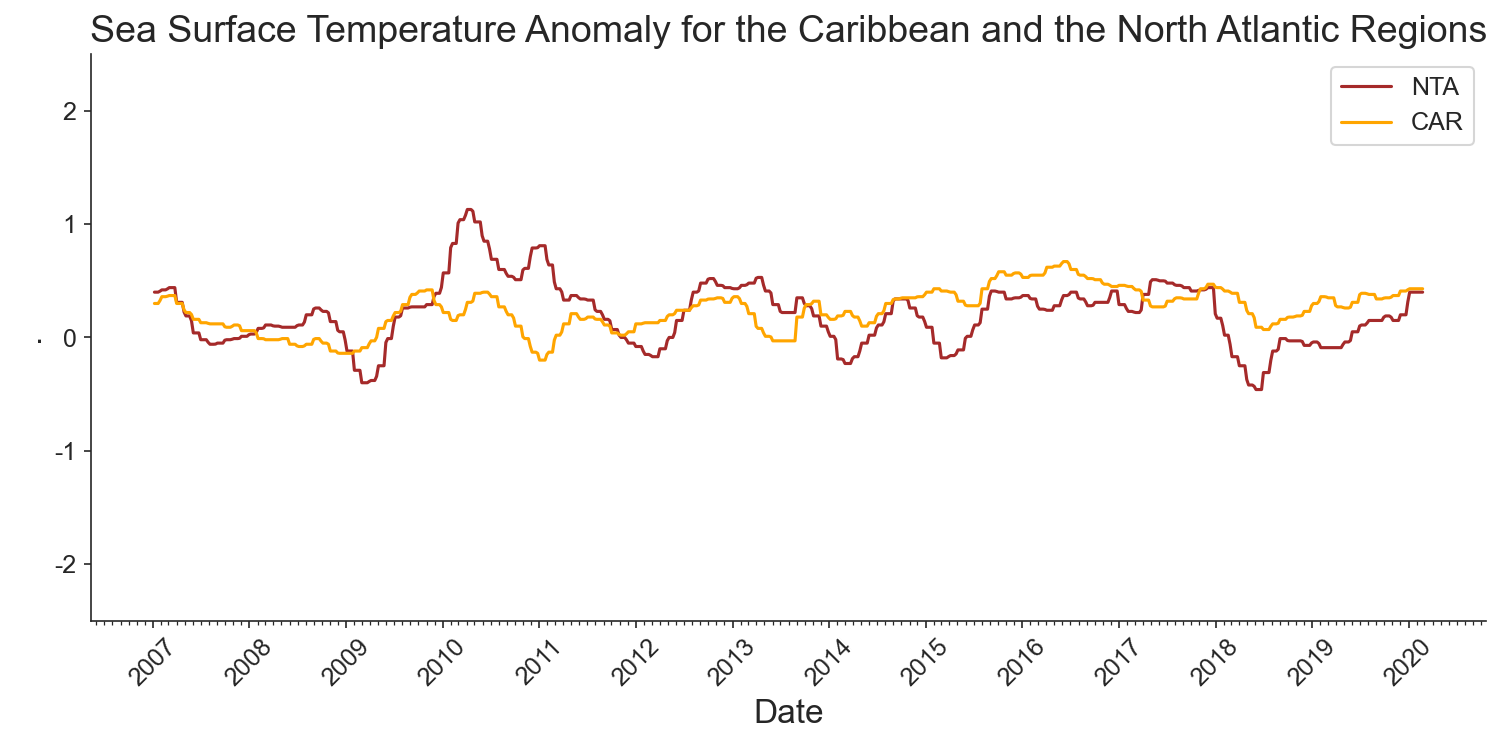

In [553]:
x_array = [df.index]*2
y_array = [df["NTA"], df["CAR"]]
labels_array = ["NTA", "CAR"]
colors = ["brown","orange"]
title = "Sea Surface Temperature Anomaly for the Caribbean and the North Atlantic Regions"
ylabel = "."
xlabel = "Date"
plot_time_series(x_array, y_array, labels_array,colors,title,  xlabel,ylabel, "lineplot", fulldates = True, ylim = [-2.5,2.5])

# DENGUE PLOTS

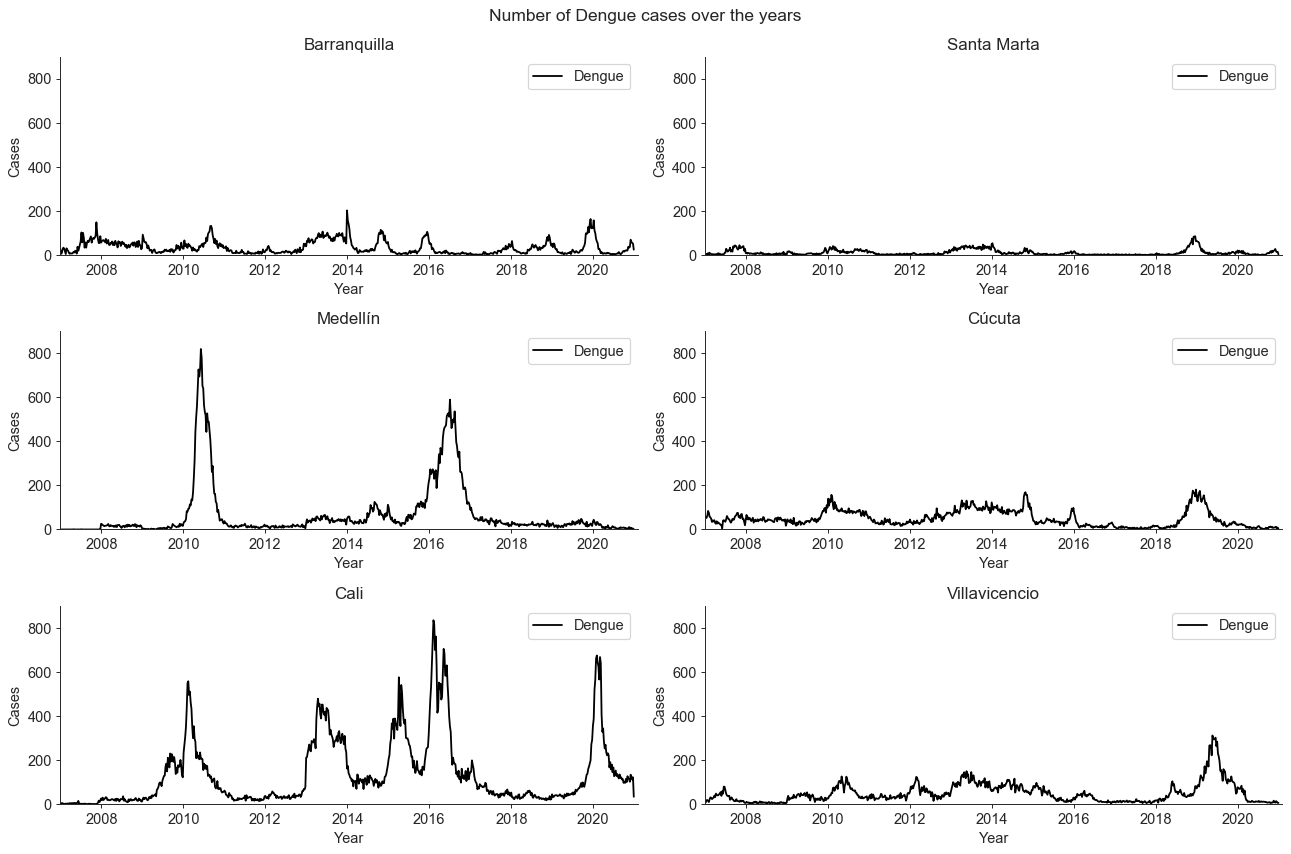

In [33]:
fig, ax = plt.subplots(3,2, figsize=figsize, dpi = dpi)
ax = ax.flatten()
for i,n in enumerate(municipios):
    df = dic_municipios[n]["df"]
    x_array = [df.index]
    y_array = [df["DENGUE"]]
    labels_array = ["Dengue"]
    title =  n
    ylabel = "Cases"
    xlabel = "Year"
    colors = ["black"]
    xlim = dates_range
    viz.plot_time_series(ax[i], x_array, y_array, labels_array, colors, title, xlabel,ylabel, xlim, (0,900),"lineplot", fulldates = False)
    plt.suptitle("Number of Dengue cases over the years")
fig.tight_layout()
plt.show()

Text(0.5, 0, 'Month')

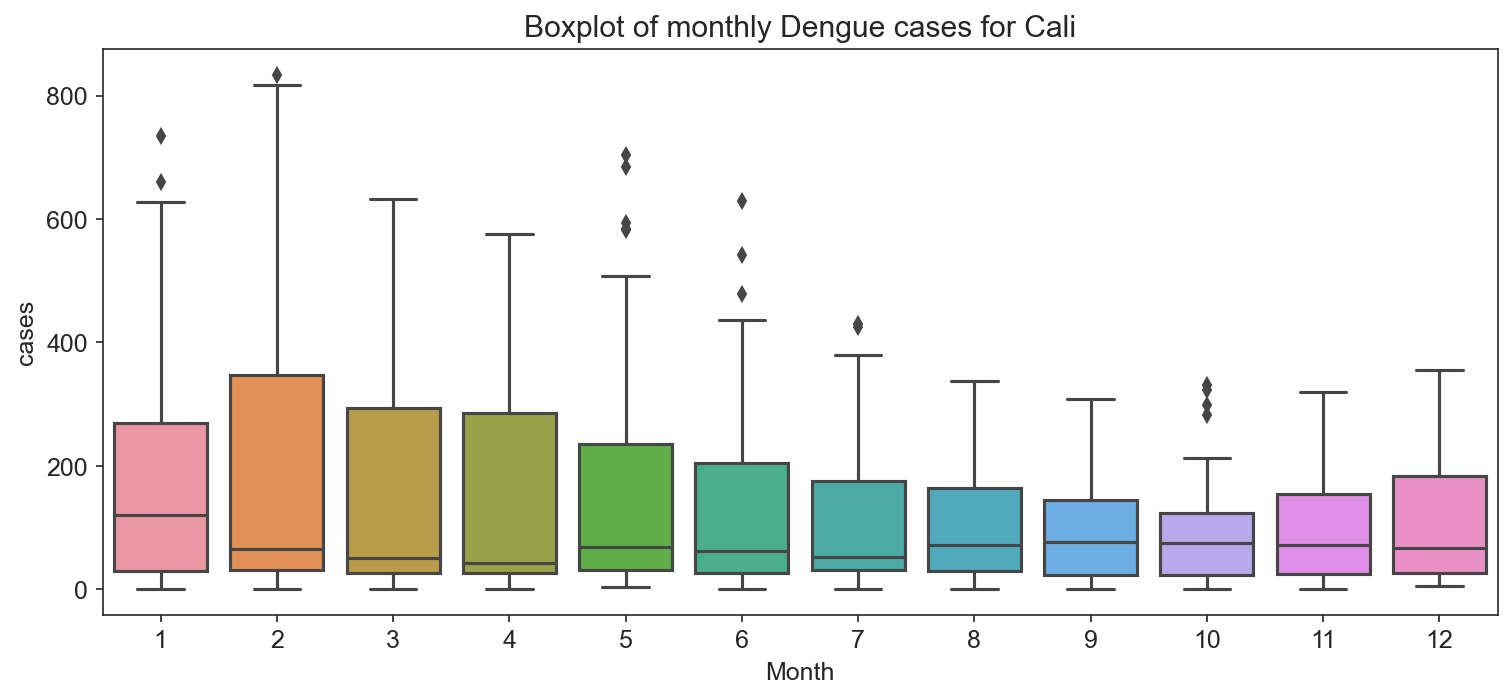

In [555]:
fig, axes = plt.subplots(1,1, figsize=(12,5), dpi = 150)
sns.boxplot(x=df.index.month, y=df["DENGUE"])
axes.set_title("Boxplot of monthly Dengue cases for " + municipality)
axes.set_ylabel("cases")
axes.set_xlabel("Month")

## BOXPLOTS FOR UNDERSTANDING THE BEHAVOIR OF EACH VARIABLE THROUGH TIME

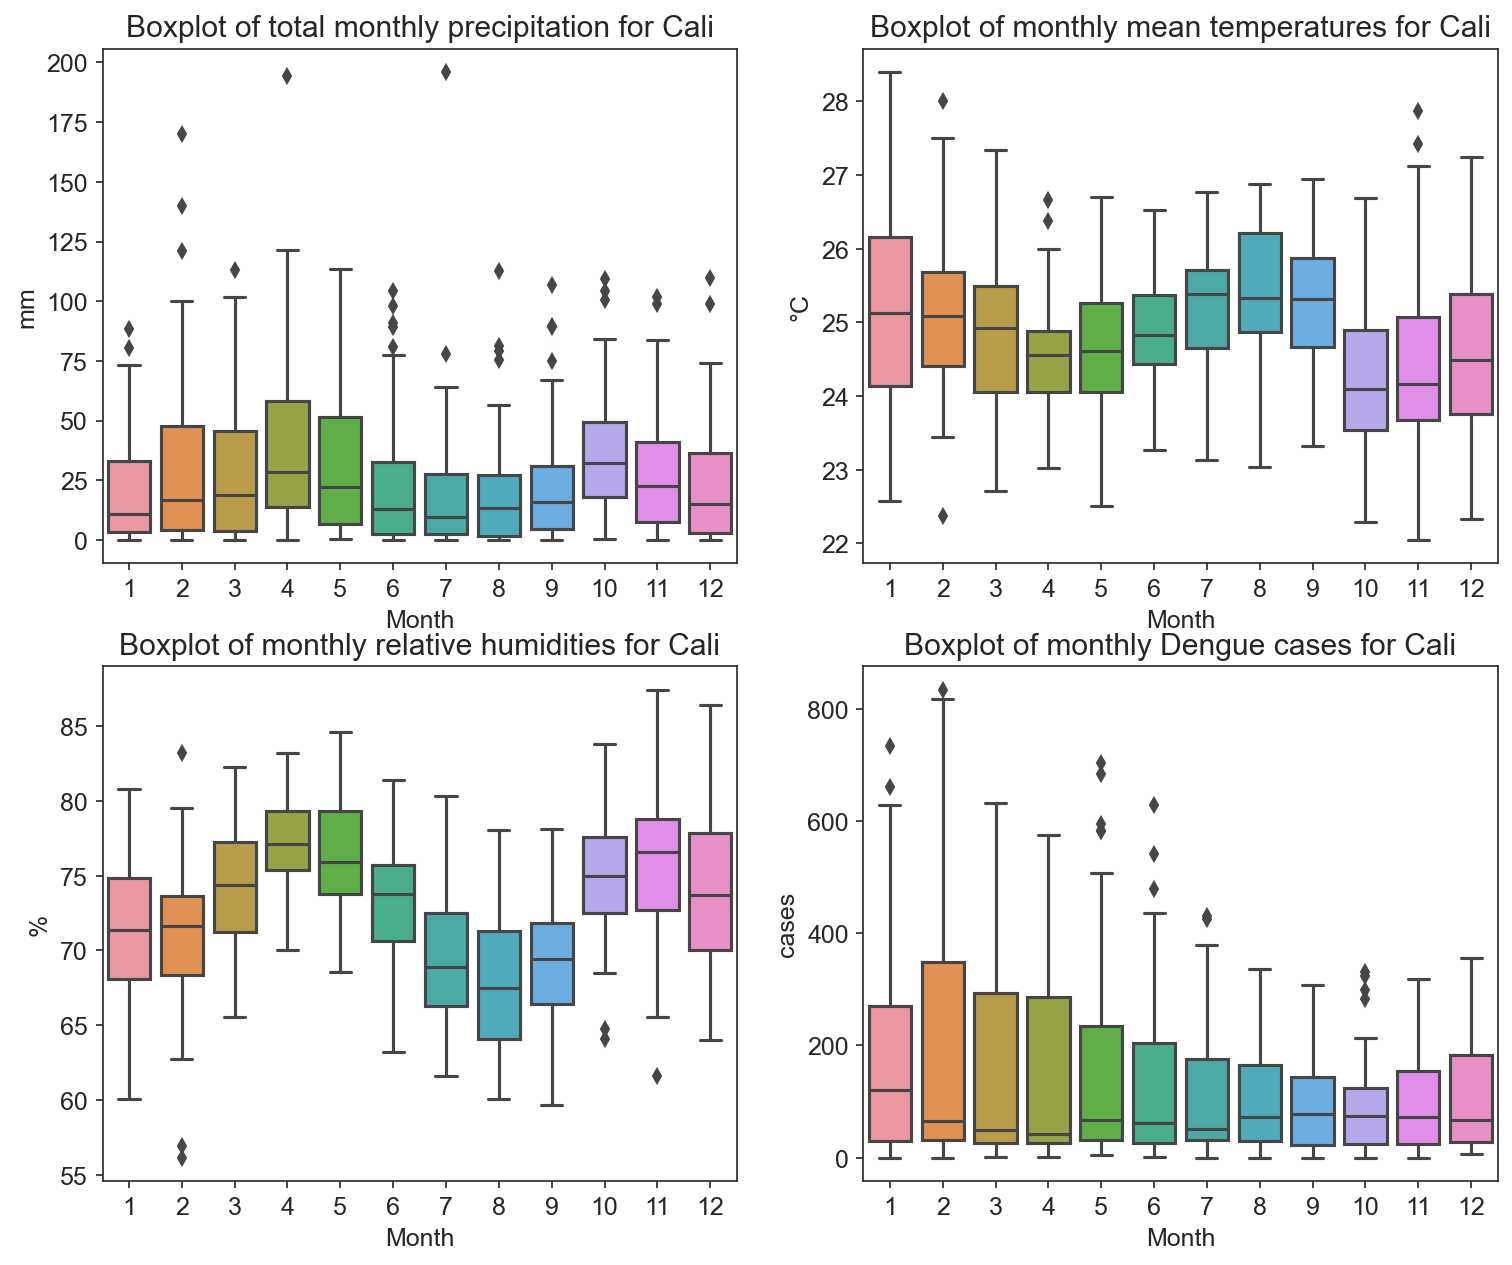

In [556]:
cols = ['PRECIPITATION', 'TEMPERATURE_MEAN', 'REL_HUMIDITY_MEAN', 'DENGUE']
titles = ["Boxplot of total monthly precipitation for ", 
          "Boxplot of monthly mean temperatures for ",
          "Boxplot of monthly relative humidities for ",
          "Boxplot of monthly Dengue cases for "]
ylables = ['mm', '°C', '%', 'cases']

fig, ax = plt.subplots(figsize=(12, 10), dpi = 150)

for i, col in enumerate(cols):
    plt.subplot(2,2, i+1)
    sns.boxplot(x=df.index.month, y=df[col]).set_title(titles[i] + municipality)
    plt.ylabel(ylables[i])
    plt.xlabel("Month")

# SIMPLE CORRELATION BETWEEN ALL VARIABLES

Some of the variables do not have to be in the correlation matrix. That's why they are removed from the beginning.

In [557]:
df_for_corr = df.drop(columns=['COD_DPTO',"COD_MUNICIPIO","POBLACION", "DENGUE GRAVE","MORTALIDAD POR DENGUE","ANO","SEMANA"])

ipykernel_launcher:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


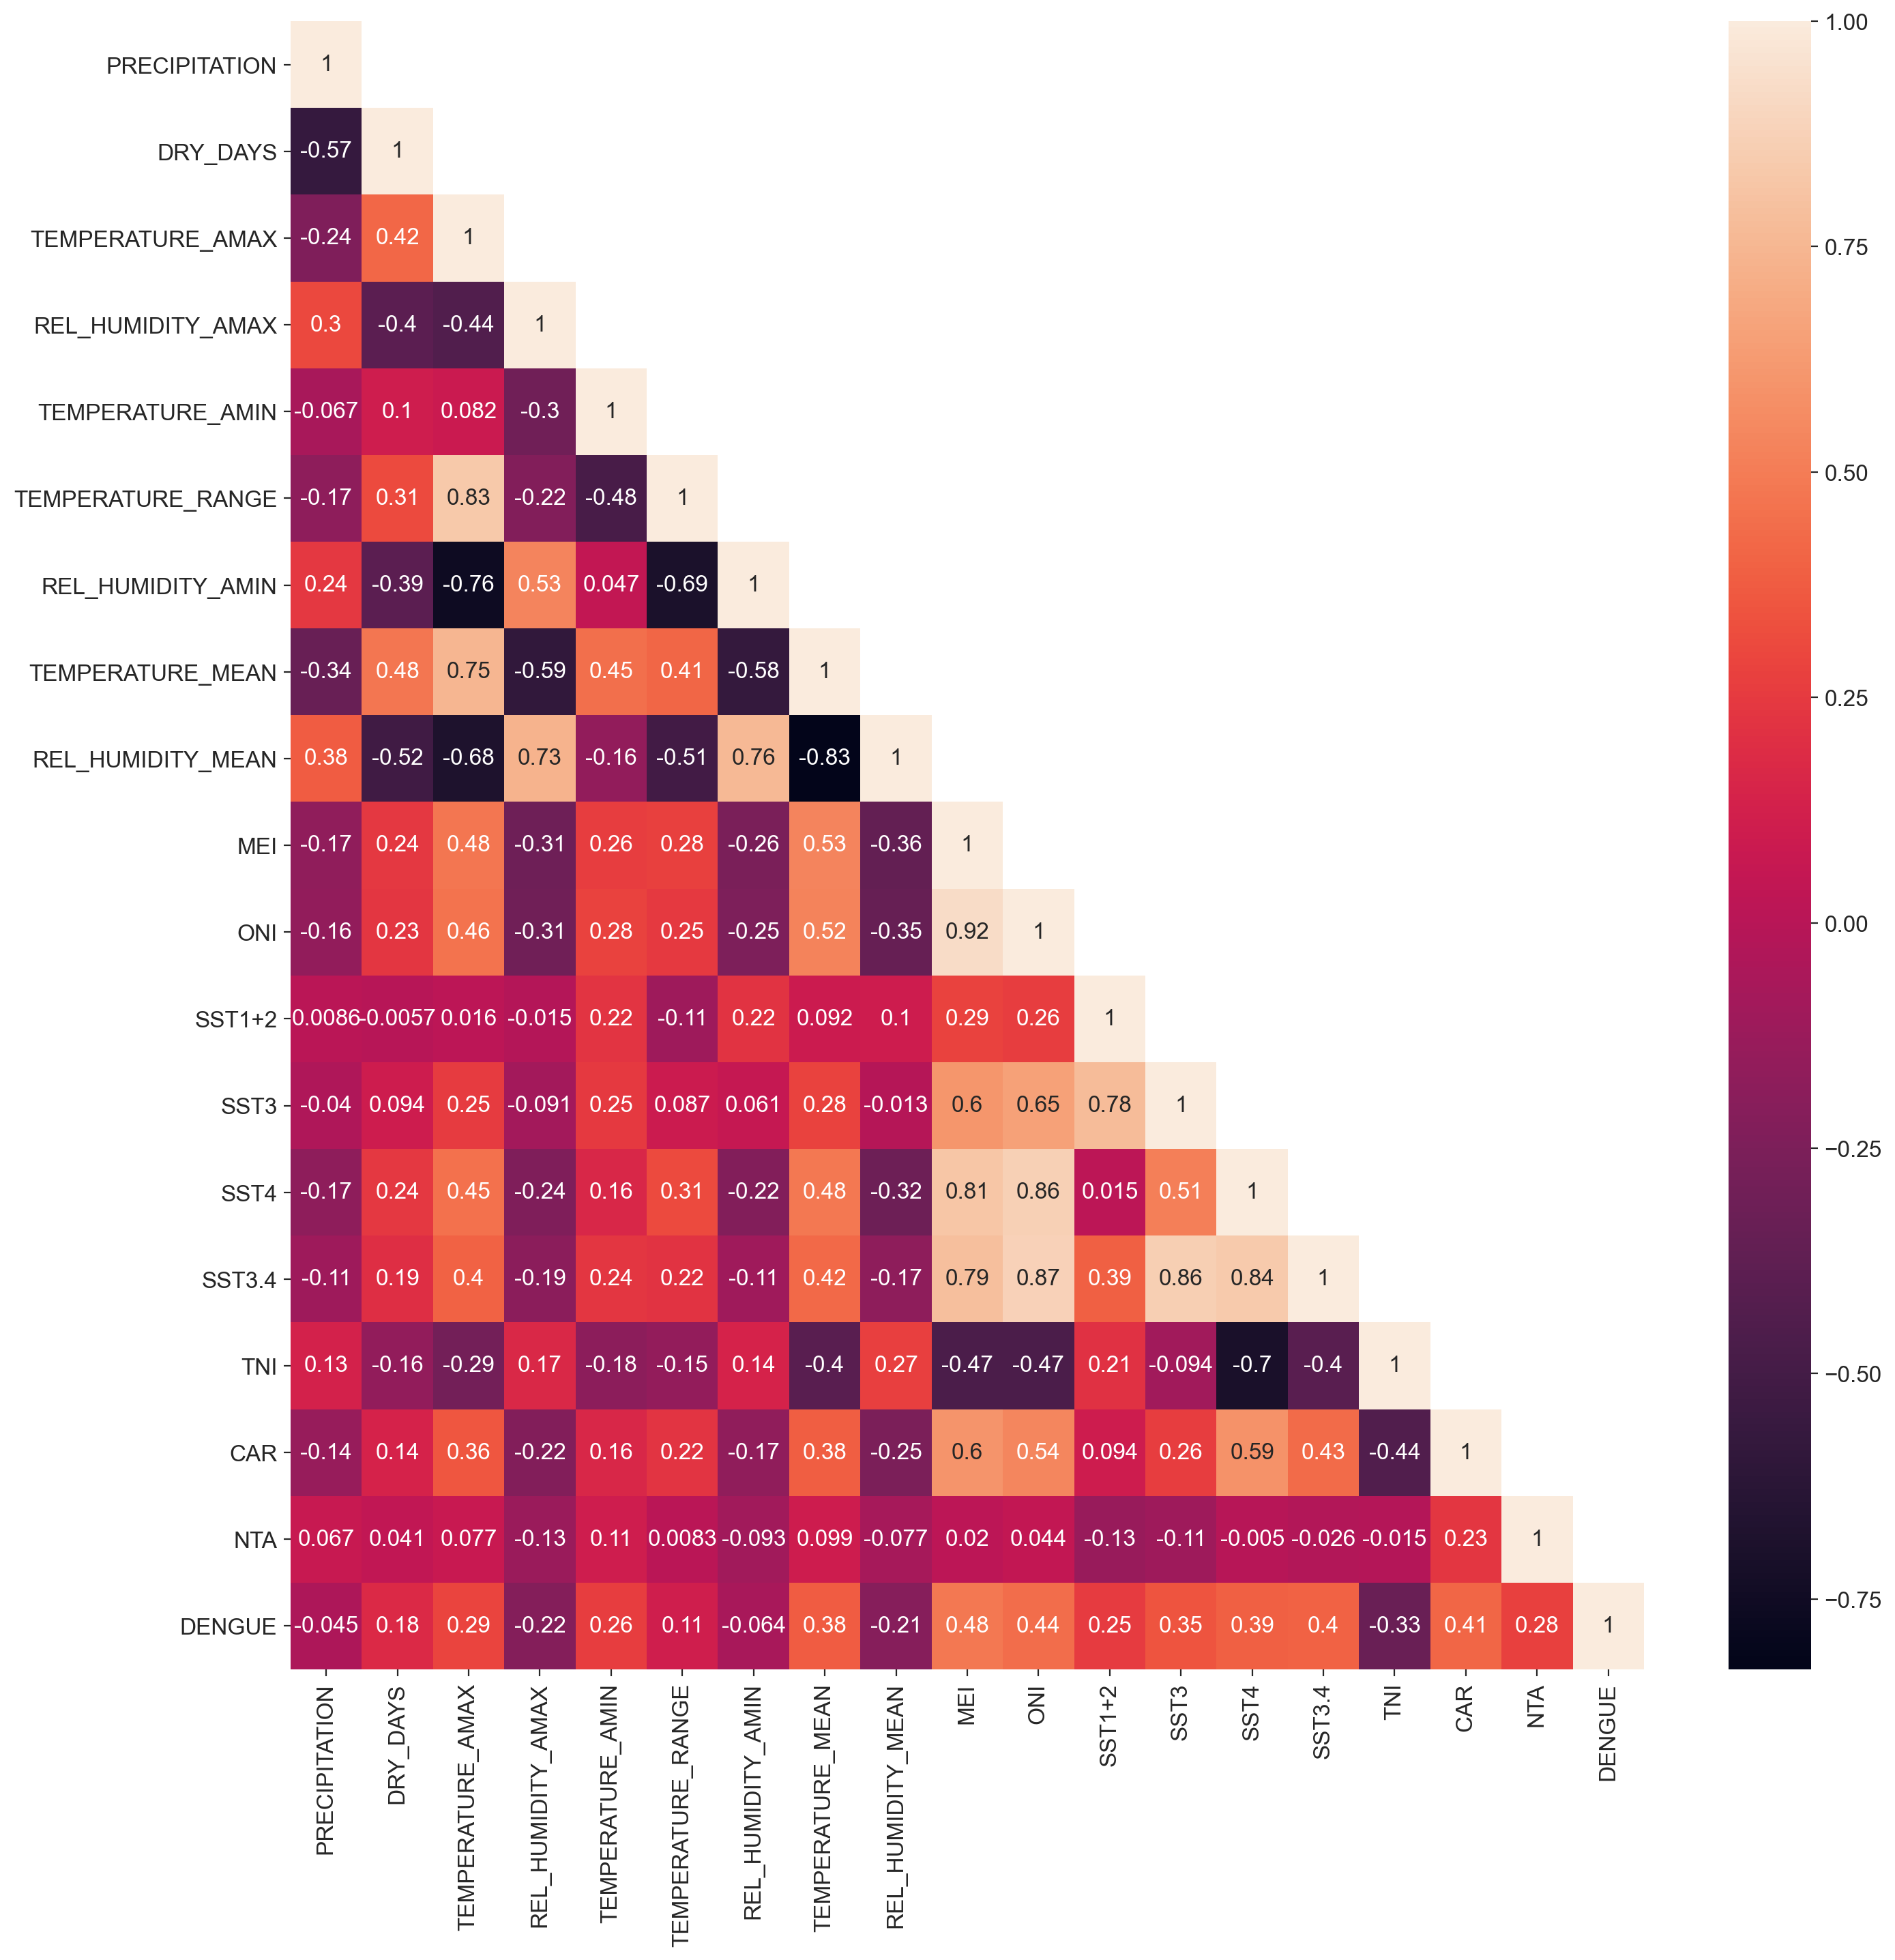

In [558]:
fig, axs = plt.subplots(1,figsize=(16,16), dpi = 200)
corrMatrix = df_for_corr.corr()
corrMatrix = corrMatrix.where(np.tril(np.ones(corrMatrix.shape)).astype(np.bool))
sns.heatmap(corrMatrix, annot=True)
plt.show()

We see that some variables are quite correlated, so we could remove some of these. Interestingly, despite being the closest to Cali the SST for Region 1+2 has the weakest correlation with Dengue cases.

From the correlation matrix we see that variables such as: mean temperature, MEI, ONI, SST4, SST3.4 and TNI are the most correlated with the number of Dengue cases.

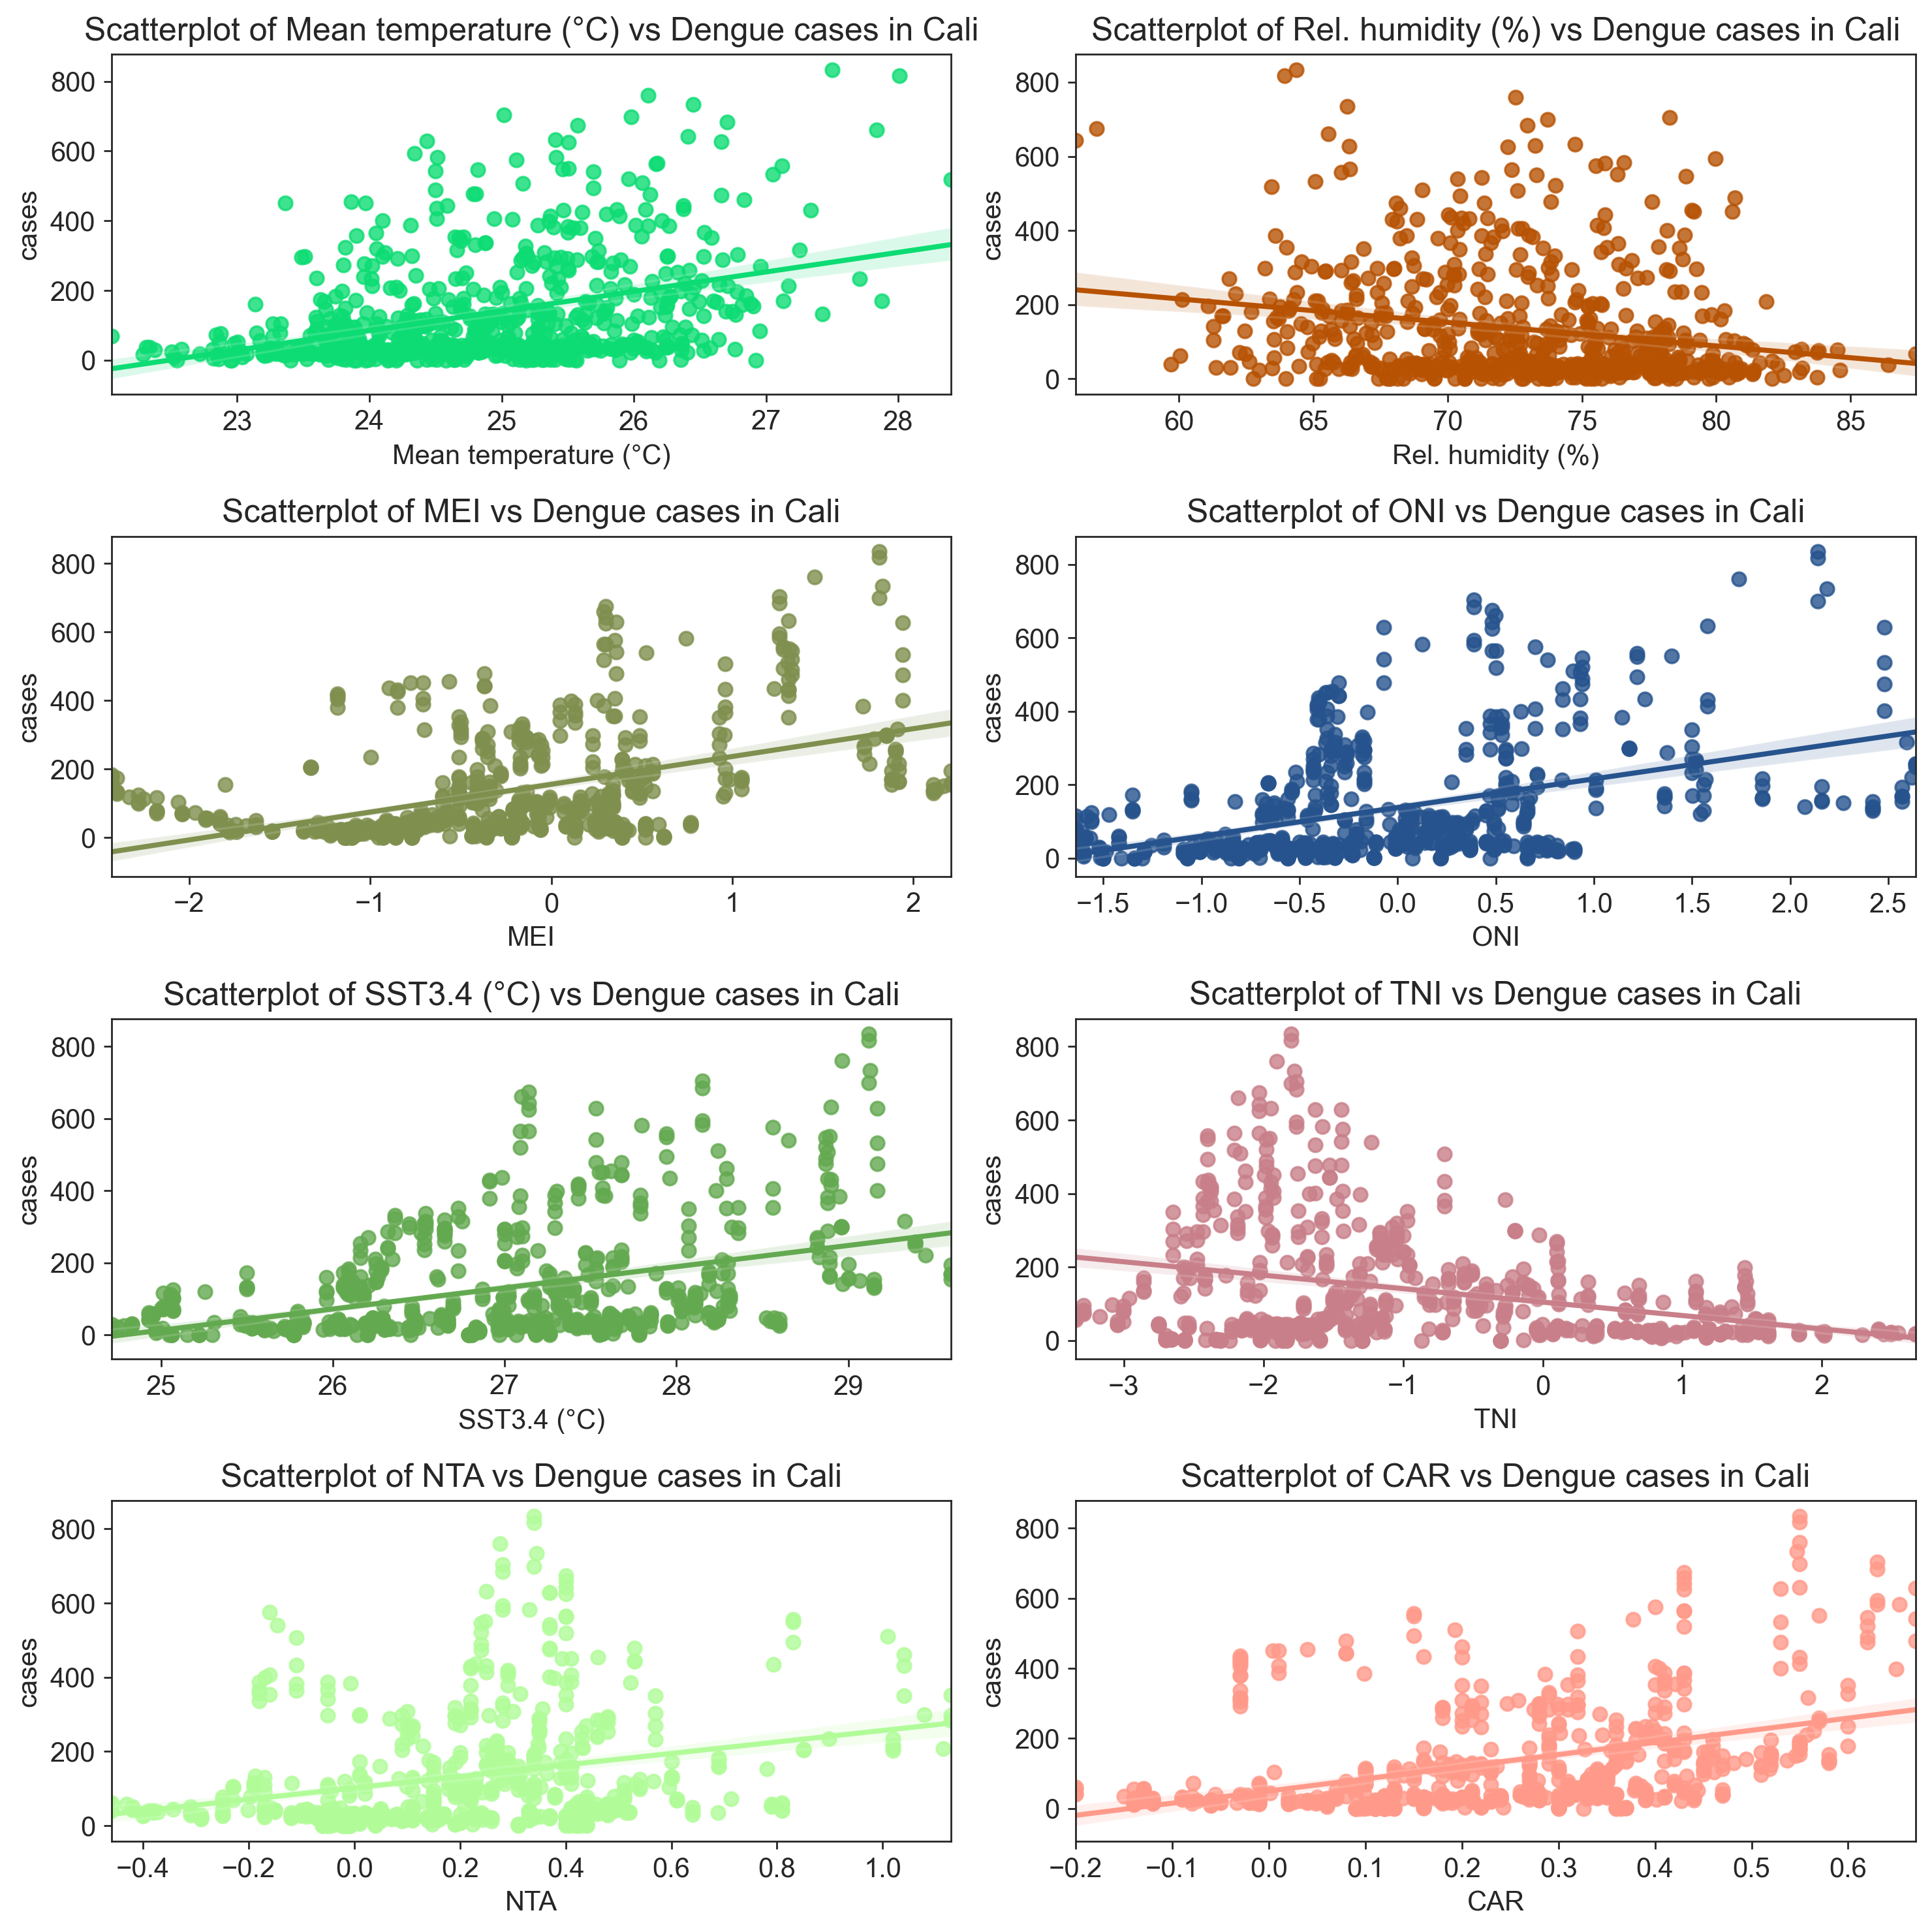

In [559]:
fig, axes = plt.subplots(4,2, figsize=(12,12), dpi = 250)
axes = axes.flatten()
vars_to_plot = ["TEMPERATURE_MEAN","REL_HUMIDITY_MEAN","MEI","ONI","SST3.4","TNI","NTA","CAR"]
xlabels  = ["Mean temperature (°C)","Rel. humidity (%)", "MEI", "ONI", "SST3.4 (°C)", "TNI","NTA","CAR"]
colors = list(mcolors.get_named_colors_mapping().keys())[99:107]
for i,var in enumerate(vars_to_plot):
    sns.regplot(x = df[var], y = df["DENGUE"], ax = axes[i], color = colors[i])
    axes[i].set_title("Scatterplot of "+xlabels[i]+" vs Dengue cases in " + municipality)
    axes[i].set_ylabel("cases")
    axes[i].set_xlabel(xlabels[i])
plt.tight_layout()

# CORRELATION OVER THE YEARS WITH DELAYS BETWEEN THE COVARIATES AND THE DENGUE CASES

In [560]:
def normalize_timeseries(df, mode = "MES", cols_to_normalize = []):
    
    df_norm = df[cols_to_normalize].copy()
    
    if mode == "NO":
        return df_norm, None, None
    elif mode == "MES":
        df_norm["MES"] = df_norm.index.month
        promedios_mensuales = df_norm.groupby("MES").mean()
        desv_esta_mensuales = df_norm.groupby("MES").std()
        prom = promedios_mensuales.values[:,0:]
        std = desv_esta_mensuales.values[:,0:]
        for i in range(len(df)):
            mes = int(df_norm.iloc[i,:].MES - 1)
            for j, col in enumerate(df_norm.columns[:-2]):
                df_norm.iloc[i,j] = (df_norm.iloc[i,j]-prom[mes,j])/std[mes,j]
        return df_norm, promedios_mensuales, desv_esta_mensuales
    elif mode == "SEASONAL_DECOMPOSE":
        df_norm = df[cols_to_normalize].copy()
        for col in cols_to_normalize[:-2]:
            decomposed = seasonal_decompose(df[col],model='additive')
            df_norm[col] = decomposed.resid+decomposed.trend
        df_norm = df_norm.dropna()
        return df_norm, None, None
    

In order to calculate the correlation of dengue with the lagged covariates a function was created. This function guarantees that a correlation is calculated for each meteorological variable for a specific number of lags against dengue (`lag_size`).  

This function lags the meteorological covariate, but does not lag the dengue variable, and according to this data it calculates the respective correlation over time.

In [561]:
cols_to_correlate = ['PRECIPITATION', 'DRY_DAYS', 'TEMPERATURE_AMAX', 'REL_HUMIDITY_AMAX',
       'TEMPERATURE_AMIN', 'REL_HUMIDITY_AMIN', 'TEMPERATURE_MEAN',
       'TEMPERATURE_RANGE', 'REL_HUMIDITY_MEAN', 'MEI', 'ONI', 'SST1+2',
       'SST3', 'SST4', 'SST3.4', 'TNI', 'NTA',"CAR","DENGUE"]
df_norm, promedios, desv_esta = normalize_timeseries(df, mode = "SEASONAL_DECOMPOSE", cols_to_normalize = cols_to_correlate)
df_norm.head(5)

PRECIPITATION  DRY_DAYS  TEMPERATURE_AMAX  REL_HUMIDITY_AMAX  \
FECHA                                                                      
2007-07-08      25.354467  4.155389         32.220316          97.011258   
2007-07-15      13.896701  3.309975         29.567069          98.321169   
2007-07-22      41.993520  2.542224         31.145390          98.242767   
2007-07-29      21.250029  3.544443         31.410035          89.245725   
2007-08-05      19.054393  1.620626         30.214029          98.026051   

            TEMPERATURE_AMIN  REL_HUMIDITY_AMIN  TEMPERATURE_MEAN  \
FECHA                                                               
2007-07-08         20.645566          46.355091         25.428935   
2007-07-15         19.590122          53.979351         23.865986   
2007-07-22         18.211062          47.365446         23.321602   
2007-07-29         20.466609          44.436451         24.997259   
2007-08-05         19.781106          50.129499         24.116858   

            TEMPERATURE_RANGE  REL_HUMIDITY_MEAN       MEI       ONI  \
FECHA                                                                  
2007-07-08          11.574750          69.302940 -0.777871 -0.614395   
2007-07-15           9.976946          75.812245 -0.729222 -0.592820   
2007-07-22          12.934328          78.029537 -0.728463 -0.591173   
2007-07-29          10.943426          69.219935 -0.808988 -0.727644   
2007-08-05          10.432923          76.151627 -0.858244 -0.822361   

               SST1+2       SST3       SST4     SST3.4       TNI       NTA  \
FECHA                                                                        
2007-07-08  21.199526  24.586908  28.475489  26.333454 -2.384158 -0.000192   
2007-07-15  21.588725  24.876298  28.513712  26.506917 -2.380844 -0.020733   
2007-07-22  21.601699  24.887587  28.513090  26.513363 -2.378619 -0.021455   
2007-07-29  21.044498  24.413615  28.393926  26.214023 -2.231616 -0.045418   
2007-08-05  21.004504  24.306493  28.356750  26.151280 -2.072699 -0.068736   

                 CAR  DENGUE  
FECHA                         
2007-07-08  0.130000       1  
2007-07-15  0.130000       1  
2007-07-22  0.130000       0  
2007-07-29  0.124286       1  
2007-08-05  0.120000       2

The variables are kept to 24 lags, because after this period of time, usually the behavior starts repeating itself. This filter allows us to reduce the noise in the data.

In [562]:
def lagged_corr(df, weeks, var, window):
    return df[str(var)].shift(periods=weeks).iloc[weeks:].corr(df['DENGUE'].iloc[weeks:], min_periods=window, method = "pearson")                                 

df_corr_melt = pd.melt(df_norm.reset_index().reset_index(), id_vars='index', value_vars=cols_to_correlate)
df_corr_melt.rename(columns={'index':'lag_size'}, inplace=True)
df_corr_melt = df_corr_melt[(df_corr_melt["lag_size"]<=15)&(df_corr_melt["lag_size"]>=3)]
df_corr_melt['corr'] = df_corr_melt.apply(lambda x: lagged_corr(df_norm, x.lag_size, x.variable, 60), axis=1)
df_corr_pivot = df_corr_melt.pivot_table(columns='lag_size', index='variable', values='corr')
row_max = np.abs(df_corr_pivot).idxmax(axis=1)
columns = row_max.index

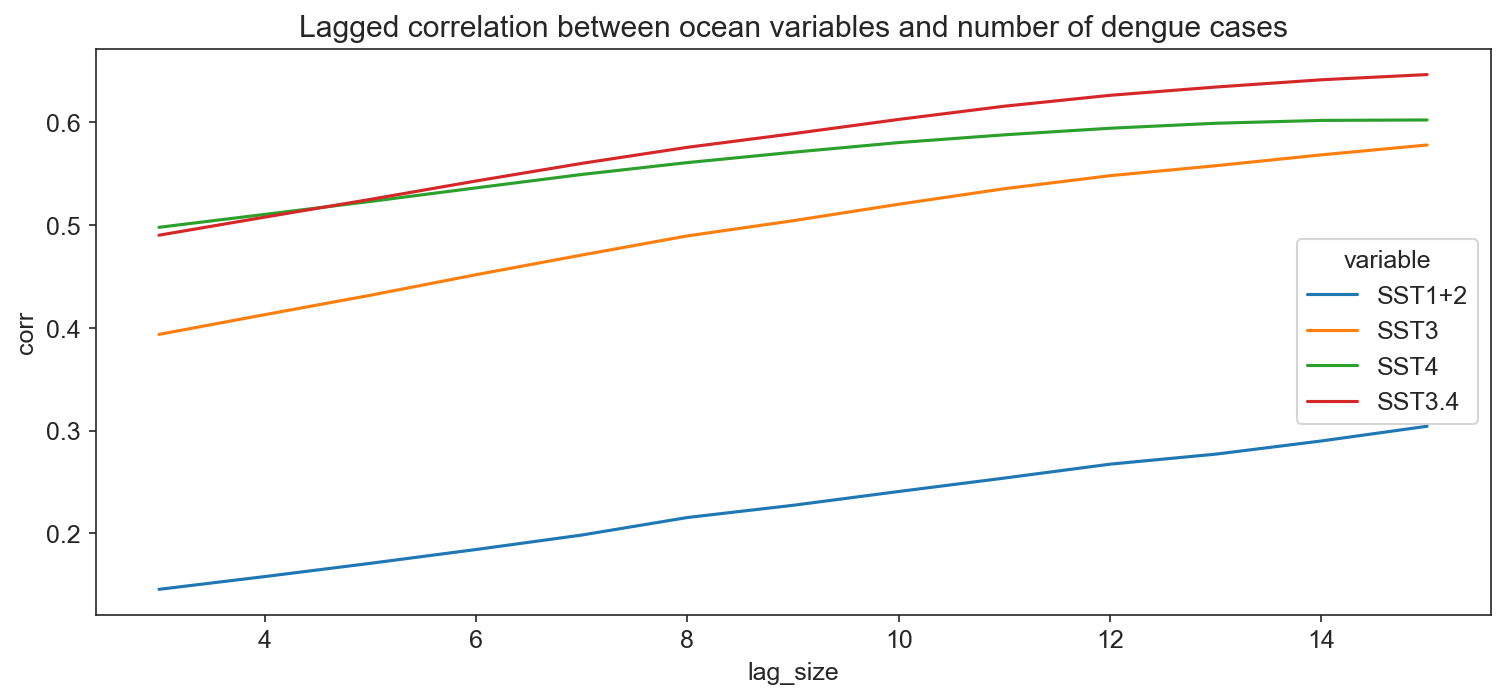

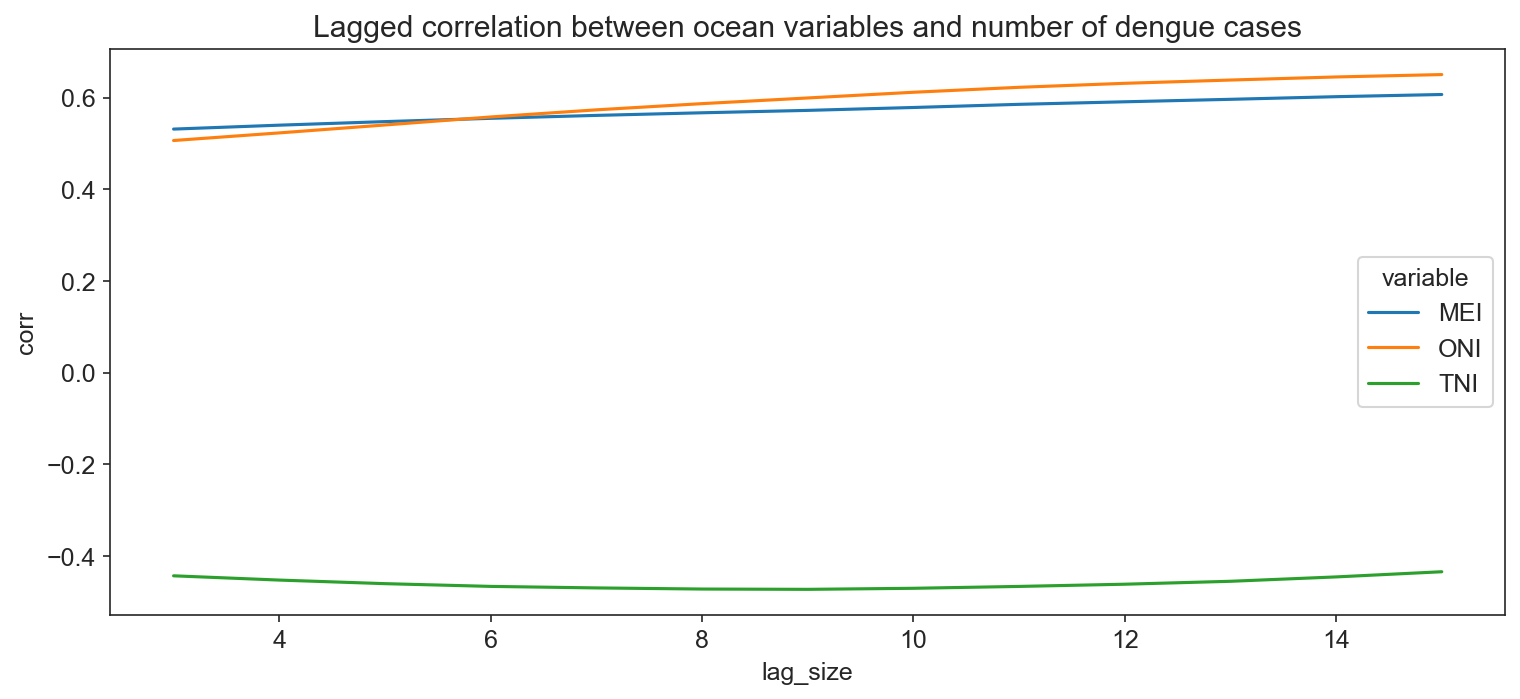

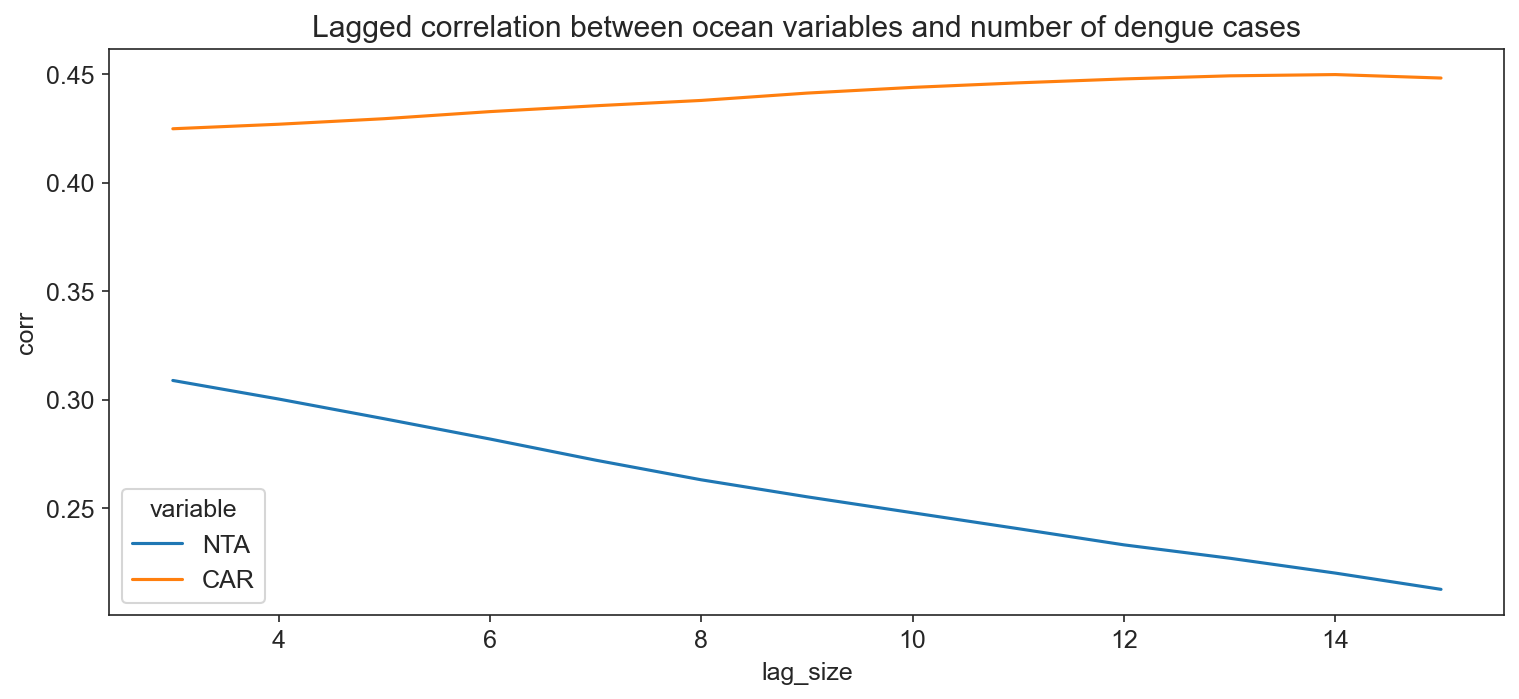

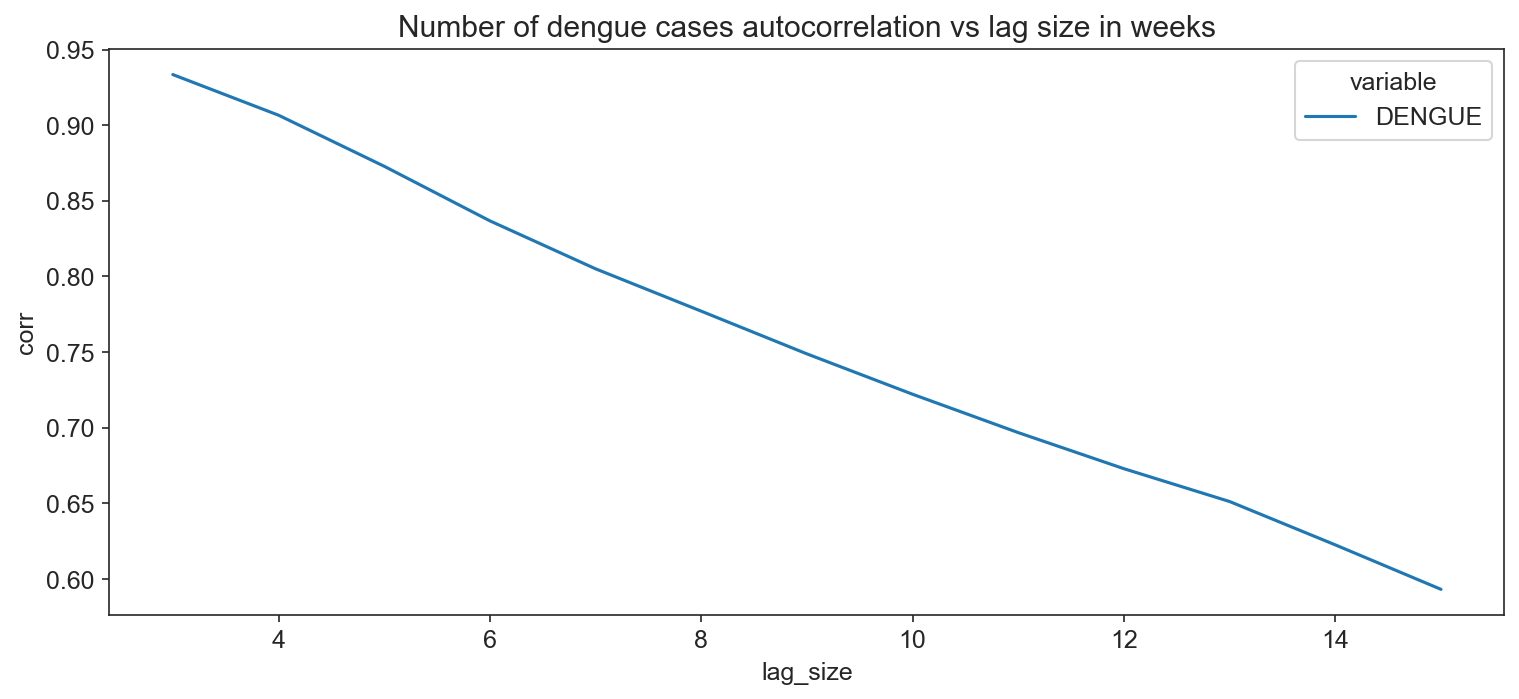

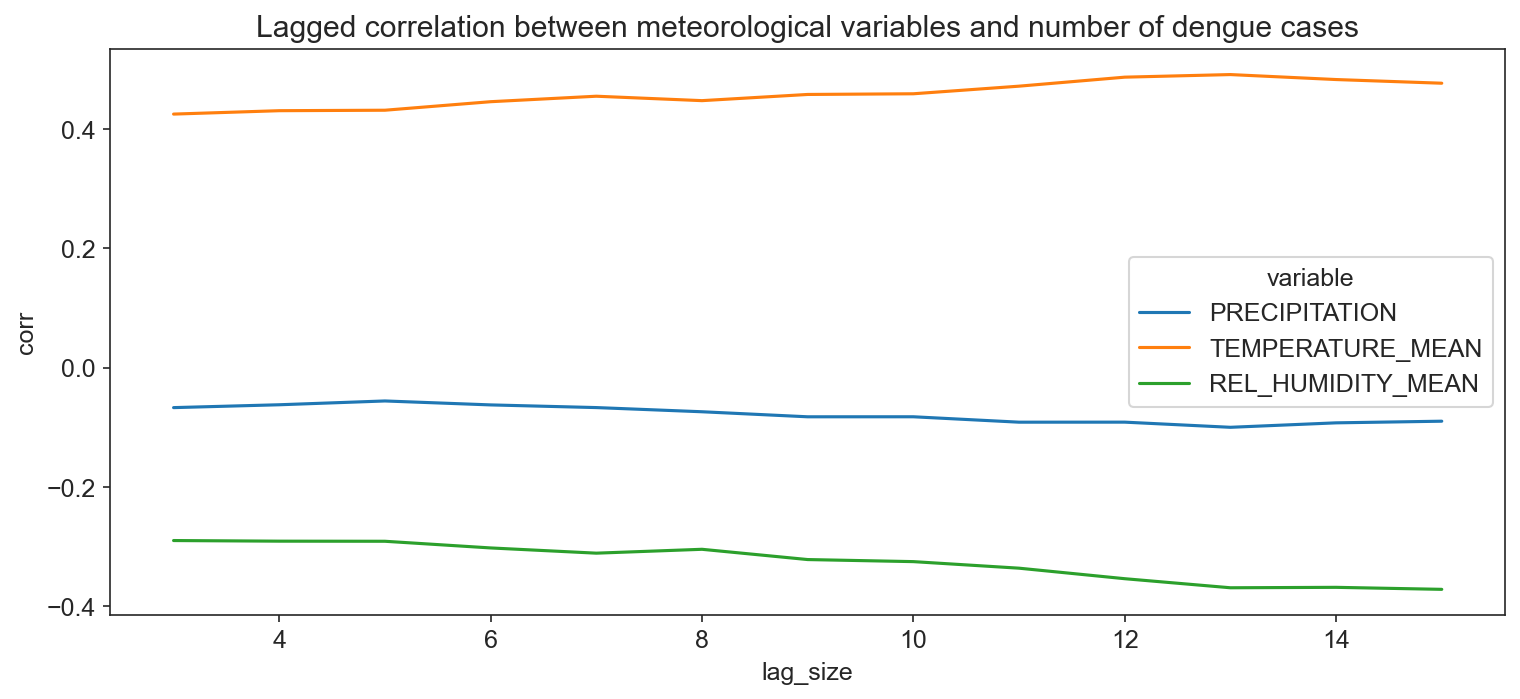

In [567]:
df_corr_melt_sub = df_corr_melt[df_corr_melt['variable'].isin(('SST1+2', 'SST3', 'SST4', 'SST3.4'))]
fig, axs = plt.subplots(figsize = (12,5), dpi=150)
ax = sns.lineplot(x='lag_size', y='corr', data=df_corr_melt_sub, hue = 'variable').set_title('Lagged correlation between ocean variables and number of dengue cases')


df_corr_melt_sub = df_corr_melt[df_corr_melt['variable'].isin(('MEI', 'ONI', 'TNI'))]
fig, axs = plt.subplots(figsize = (12,5), dpi=150)
ax = sns.lineplot(x='lag_size', y='corr', data=df_corr_melt_sub, hue = 'variable').set_title('Lagged correlation between ocean variables and number of dengue cases')

df_corr_melt_sub = df_corr_melt[df_corr_melt['variable'].isin(("NTA","CAR"))]
fig, axs = plt.subplots(figsize = (12,5), dpi=150)
ax = sns.lineplot(x='lag_size', y='corr', data=df_corr_melt_sub, hue = 'variable').set_title('Lagged correlation between ocean variables and number of dengue cases')


df_corr_melt_sub3 = df_corr_melt[df_corr_melt['variable'] == 'DENGUE']
fig, axs = plt.subplots(figsize = (12,5), dpi=150)
ax = sns.lineplot(x='lag_size', y='corr', data=df_corr_melt_sub3, hue = 'variable').set_title('Number of dengue cases autocorrelation vs lag size in weeks')

df_corr_melt_sub2 = df_corr_melt[df_corr_melt['variable'].isin(('TEMPERATURE_MEAN', 'REL_HUMIDITY_MEAN', 'PRECIPITATION'))]
fig, axs = plt.subplots(figsize = (12,5), dpi=150)
ax = sns.lineplot(x='lag_size', y='corr', data=df_corr_melt_sub2, hue = 'variable').set_title('Lagged correlation between meteorological variables and number of dengue cases')

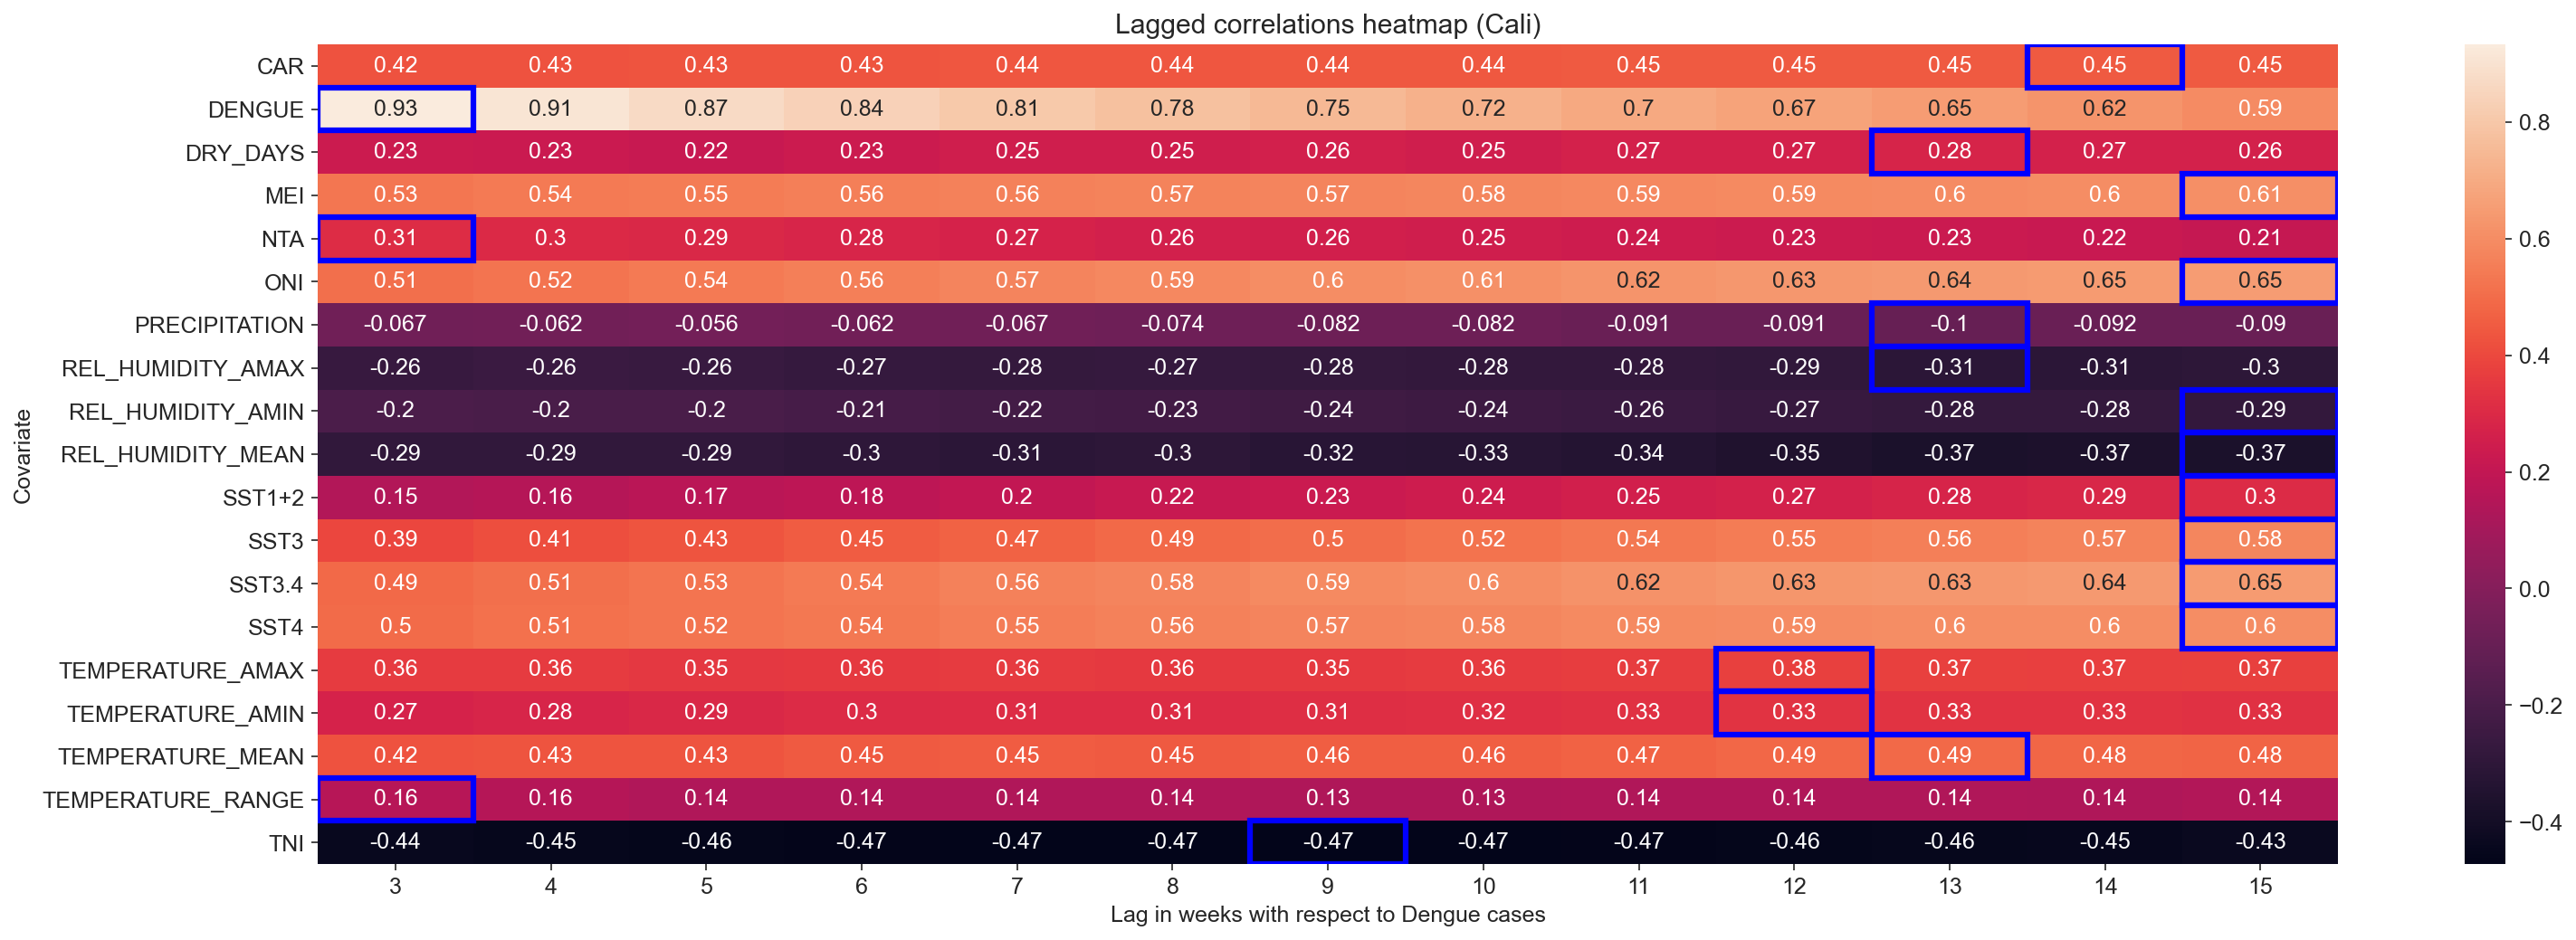

In [565]:
fig, ax = plt.subplots(1,1, figsize=(24,8), dpi = 150)
sns.heatmap(df_corr_pivot, annot = True, ax = ax)
ax.set_xlabel("Lag in weeks with respect to Dengue cases")
ax.set_title("Lagged correlations heatmap ({})".format(municipality))
ax.set_ylabel("Covariate");
for row, index in enumerate(columns):
    position = df_corr_pivot.columns.get_loc(row_max[index])
    ax.add_patch(Rectangle((position, row),1,1, fill=False, edgecolor='blue', lw=3))


The following function is done with the purpose of calculating the correlation between the meteorological variables and the lagged dengue, this variable is lagged up to 17 times and the `phases_confirmed` dataframe shows the result of this calculations.

In [566]:
"""def obtener_conjunto_desfasado(datos,meses_desfase):
    dat_desfase = datos.copy().reset_index(drop=True)
    for i in range(len(dat_desfase)-meses_desfase):
        dat_desfase.loc[i,"DENGUE_UNPHASED"] = dat_desfase.loc[i+meses_desfase,"DENGUE"]
    quitar_filas = list(range(len(dat_desfase)-meses_desfase,len(dat_desfase)))
    dat_desfase= dat_desfase.drop(dat_desfase.index[quitar_filas])
    return dat_desfase
phases_confirmed

df_for_corr_2 = df_for_corr[cols_to_correlate]
phases = [obtener_conjunto_desfasado(df_for_corr_2, i).corr(method='pearson').iloc[:,-1:] for i in range(24)]
phases_confirmed = pd.concat(phases, axis = 1)

fig, ax = plt.subplots(1,1, figsize=(24,8), dpi = 150)
sns.heatmap(phases_confirmed, annot = True, ax = ax)
ax.set_xlabel("Lag in weeks with respect to Dengue cases")
ax.set_title("Lagged correlations heatmap ({})".format(municipality))
ax.set_ylabel("Covariate");
"""

'def obtener_conjunto_desfasado(datos,meses_desfase):\n    dat_desfase = datos.copy().reset_index(drop=True)\n    for i in range(len(dat_desfase)-meses_desfase):\n        dat_desfase.loc[i,"DENGUE_UNPHASED"] = dat_desfase.loc[i+meses_desfase,"DENGUE"]\n    quitar_filas = list(range(len(dat_desfase)-meses_desfase,len(dat_desfase)))\n    dat_desfase= dat_desfase.drop(dat_desfase.index[quitar_filas])\n    return dat_desfase\nphases_confirmed\n\ndf_for_corr_2 = df_for_corr[cols_to_correlate]\nphases = [obtener_conjunto_desfasado(df_for_corr_2, i).corr(method=\'pearson\').iloc[:,-1:] for i in range(24)]\nphases_confirmed = pd.concat(phases, axis = 1)\n\nfig, ax = plt.subplots(1,1, figsize=(24,8), dpi = 150)\nsns.heatmap(phases_confirmed, annot = True, ax = ax)\nax.set_xlabel("Lag in weeks with respect to Dengue cases")\nax.set_title("Lagged correlations heatmap ({})".format(municipality))\nax.set_ylabel("Covariate");\n'